In [140]:
reset() # this is a sagemath command
print(" we change the style for the markdown cells")
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

 we change the style for the markdown cells


Bibliography : https://www.aimsciences.org/article/exportPdf?id=c1bbdc4c-a492-4dd6-b9de-88a63ed039e6

Δεν θα πάω κατευθείαν στο $n\times n$ αλλά θα σου δειξω πως γίνεται η επίθεση για μια εξίσωση και μετα για περισσότερες εξισώσεις (δηλ. για πίνακα $m\times n$ με $m<n$ και $m\ge 1$).
<br>
$m$ : number of equations
<br>
$n$ : number of unknowns

**[1]** Let a $m\times n$ matrix $A$ (with $m<n$) with entries in $I_{R/2},$ where 
<br>
$I_R$ the set of $R$-bits integers. We use the following code for the generation of the matrix.
<br>
If we consider $m=1$ we have the case of only one equation (as in the paper)
<br>
We have to see also the case $m=n.$ I.e. the matrix $A$ is rectangular.
<br>
In this case we must have $\det(A)=0.$
<br>
<span style="color:blue">TODO </span>: How to very fast generate a matrix with $\det(A)=0$
<br>
It is not a good idea to compute $\det(A)$.
<br>
Also we need to define 
$${\mathcal{S}}_1=I_R^n$$
$${\mathcal{S}}_2=I_R^{n/2}\times I_{R/2}^{n/2}$$
$${\mathcal{S}}_3=I_{R/2}^{n/2}\times I_{R/4}^{n/2}$$
$${\mathcal{S}}_4=I_{R/2}^{n/3}\times I_{R/4}^{n/3}\times I_{R/8}^{n/3}$$
$${\mathcal{S}}_5=I_{R}^{n/4}\times I_{R/2}^{n/4}\times I_{R/4}^{n/5}\times I_{R/8}^{n/4}$$
$${\mathcal{S}}_6=I_{R}^{n/5}\times I_{R/2}^{n/5}\times I_{R/4}^{n/5}\times I_{R/8}^{n/5}\times I_{R/16}^{n/5}$$

In [141]:
# some auxiliary functions
def bits(n):
    return floor(log( max ( abs(n), 1) ,2))+1

In [142]:
# definition of I_R
R = 20 # choose for simplicity R to be even
# definition of n and m
n = 24 # so we work in dimension n,i.e. we have n unknowns
m = 1 # we have m equations.

mode = 2
# generation of a matrix with elements from I_{R/2}
left  = 2^((R/mode)-1)
right = 2^(R/mode) - 1

# Now, we generate a matrix with (n-1) rows, and random integer elements from the interval [left, right]
A = matrix( [vector([ZZ.random_element(left,right+1) for _ in range(n)]) for _  in range(m)] )

**[2]** we generate a solution ${\bf x} \in {\mathbb{Z}}^n,$ which satisfies $A{\bf x} = {\bf b}$.
<br>
Since we shall define ${\bf x}$ making the multiplication $A{\bf x}$ we compute ${\bf b}.$ 
<br>
The solution vector ${\bf x}$ is the crucial component that makes the problem hard.

In [117]:
# if index = 1 we choose x from S1
# if index = 2 we choose x from S2
# TODO:if index = 3 we choose x from S3


# choose index
index =  2

if index == 1:
    left1  = 2^(R-1)
    right1 = 2^R - 1
    x = vector([ZZ.random_element(left1 , right1 + 1) for _ in range(n)])

if index == 2:
    left1   = 2^(R-1)
    right1  = 2^R - 1
    left2   = 2^(R/2 - 1)
    right2  = 2^(R/2) - 1
    x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/2)]
    x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/2)]
    x = vector(x1+x2)
    
if index == 3:
    left1   = 2^(R/2-1)
    right1  = 2^(R/2) - 1
    left2   = 2^(R/4 - 1)
    right2  = 2^(R/4) - 1
    x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range( int(n/2))]
    x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range( int(n/2))]
    x = vector(x1+x2)


if index == 4:
        left1   = 2^(R/2-1)
        right1  = 2^(R/2) - 1
        left2   = 2^(R/4 - 1)
        right2  = 2^(R/4) - 1
        left3   = 2^(R/8 - 1)
        right3  = 2^(R/8) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/3)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/3)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/3)]
        x = vector(x1+x2+x3)
        
    
print("secret key x:",x)
# we compute also the vector b
b = (A*x) # όταν το m=1 απλα υπολογιζουμε το εσωτερικό γινόμενο
print("b:",b)

secret key x: (704736, 945649, 977776, 1046956, 594767, 1044835, 578436, 780404, 609955, 1042704, 839686, 825926, 756, 644, 554, 871, 986, 744, 942, 815, 965, 563, 653, 747)
b: (7682337932)


**[3]** We shall find a basis of the lattice generated by the solutions of the homogeneous system
$A{\bf x}={\bf 0}.$
<br>
<span style="color:blue">ερώτηση </span>: Θελω να μου εξηγησεις γιατι η Smith Form ενός πίνακα μας δίνει την βάση που θέλουμε. Βρες ίσως κάποια βιβλιογραφία.

In [118]:
#rank of the lattice
def rank_of_L(A):
    '''
    outputs three integers. 
    [1] the rank of the lattice Ax=0, which is equal to (number of columns of A)-(rank(A)), 
    This is in fact the dimension of the nullspace(A).
    [2] the number of columns k and 
    [3] the rank r of A
    '''
    k=A.dimensions()[1] # number of columns
    r=A.rank()
    return k-r,k,r # rank of lattice, number of columns, rank of the matrix

#basis of the lattice L:ΑΧ=0
def kernel(A):
    # A is n x k matrix
    Rank,k,r = rank_of_L(A)
    print("rank of the lattice:",Rank ) # αυτό είναι απο το θεώρημα της διάστασης.
    Q=A.smith_form()[2] # snf(A)=PAQ
    # From [1] https://core.ac.uk/download/pdf/82343294.pdf we get that 
    # the last k-r columns of Q is a basis for the lattice Ax=0
    X=matrix(ZZ,[Q.column(i) for i in range(r,k)])
    if k-r<5: # we print the basis if it has a small dimension
        print("A basis of the lattice is:")
        print(X)
    return X

In [119]:
index

2

In [120]:
if index==2 or index==3:
    k=2
if index==4:
    k=3

In [121]:
#string = 'first_approach'
string = 'second_approach'
if string=='first_approach':
    basis = kernel(A)
if string=='second_approach':
    if index==2 or index==3:
        A1 = matrix(A[0][:n/2])
        A2 = matrix(A[0][n/2:])
        basis1 = kernel(A1)
        basis2 = kernel(A2)
    if index==4:
        A1 = matrix(A[0][:n/3])
        A2 = matrix(A[0][n/3:2*n/3])
        A3 = matrix(A[0][2*n/3:])
        basis1 = kernel(A1)
        basis2 = kernel(A2)
        basis3 = kernel(A3)

rank of the lattice: 11
rank of the lattice: 11


To προηγούμενο σημαίνει ότι οποιαδήποτε λύση του ομογενους συστήματος είναι γραμμικώς συνδυασμός των διανυσμάτων της βάσης (γραμμικη αλγεβρα 1ου εξαμηνου!)
<br>
https://elearning.auth.gr/pluginfile.php/2165668/mod_resource/content/0/2021-12-04-Note-20-49.pdf

Σύμφωνα με την επίθεση του paper https://drive.google.com/drive/folders/1pxn9SWz4Ri1CKcEatAFhcJVvUV9jO1Wv
πρέπει να βρουμε μία λύση του μη ομογενούς συστήματος, δηλ. $AX=b$
<br>
Aυτο το πρόβλημα είναι σχετικα εύκολο. Μπορεί να λυθει με Ευκλειδειο αλγόριθμο. Εμεις, θα βρουμε μια λύση με χρηση του LLL. Μπορείς να δεις το paper που εξηγει την μέθοδο 
https://github.com/drazioti/Papers/blob/master/paper/C3_soia2014.pdf
<br>
Άρα το επόμενo βήμα [4] είναι το εξής :

**[4]** Find a solution of $AX=b$
<br>
The following algorihm ( a_solution() ) is working only for $m=1$
<br>
Πιο κάτω δίνουμε και τον γενικότερο αλγόριθμο

In [122]:
'''
input   : dimension n, a vector a = [a1,a2,...,an], a target integer b 
          and a parameter Y which represents a bound for the solution, i.e. 
          we search for solutions |x_i|<Y. So choose Y large.
          
output  : a solution of the equation a1x1+a2x2+...+anxn=b, possibly satisfies |xi|<Y
'''

def a_solution(n,a,b,Y):    
    r=0;    
    #construction of the matrix
    zerom=matrix(QQ,1,[r for i in range(0, n)]); # part of the last row
    X=[Y for i in range(0, n)];
    L=matrix(QQ,2,[[0 for i in range(0, n)],[a[i] for i in range(0, n)]]);
    L=L.transpose();
    M = identity_matrix(ZZ, n);
    M=matrix(QQ,n,[1/X[i]*M.row(i) for i in range(0,n)]);
    Mb=block_matrix([[M,L]]);
    zerom1=block_matrix([[zerom,1,-b]]);  # this is the last row
    Mb1=Mb.stack(zerom1);    
    L=Mb1.LLL();   #use LLL algorithm for basis reduction
    L1=[[(L[j][i]-r)*X[i] for i in range(0,n)] for j in range(0,n+1)];#if the last row has 1/2 instead of 0
    L2=[vector(L1[i]).dot_product(vector(a))-b for i in range(0,n+1)];
    if L2.count(0)>0:
        print("Euclidean length of the solution:",float(vector(L1[L2.index(0)]).norm()))
        print("One solution is:",L1[L2.index(0)])
        return L1[L2.index(0)]
    else:
        print("NULL")
        return "NULL"
    
# ο γενικότερος αλγόριθμος, για πολλές εξισώσεις
# Αρχικα φτιαχνουμε την δομη του πίνακα σύμφωνα με το paper 
# Karen Aardal, Cor A. J. Hurkens and Arjen K. Lenstra, 
# Solving a System of Linear Diophantine Equations with Lower and Upper Bounds on the Variables.
# Στο επόμενο βήμα βρίσκουμε μια λύση του συστηματος Ax=b.
# H επιθεση μετα συνεχίζει κανονικά, δηλ. CVP

'''
input   : dimension n, a matrix mxn A = [aij], a vector d
          and two parameters N1, N2.
          
output  : a solution of the system Ax=d

'''


def construction_of_matrix(A,d,N1,N2):
    # A is matrix, d is a column matrix, N1,N@ two large integers N1<N2
    # we define the rows (m) and columns (n)
    n,m=A.dimensions()[1] , A.dimensions()[0]
    # construction of the matrix
    zerom1 = matrix(QQ,1,[0 for i in range(0, n)]).T;     # 0_{nx1}
    zerom2 = matrix(QQ,1,[0 for i in range(0, n)]+[N1]);  # [0_{1xn},N1]
    In = identity_matrix(ZZ, n);
    upper_block = block_matrix([[In,zerom1]]);
    medium_row = zerom2
    lower_block = block_matrix([[N2*A,-N2*d]]);
    final_matrix = block_matrix(3,[ [upper_block], [zerom2], [lower_block]])
    return final_matrix.T

def a_solution_of_the_system(A,d,N1,N2):
    B=construction_of_matrix(A,d,N1,N2)
    Blll = B.LLL()
    #in order to find the solutions
    # you have to find the row that has the entry N1 i.e.
    # we are looking for a row of the form (....,N1,...)

    nrows = Blll.dimensions()[0]
    for i in range(nrows):
        if N1 in Blll.row(i):
            t = i
            solution = Blll.row(t)[:nrows-1]
            print("solution:",solution)
            
            return solution
    print("error")
    return "error"
    

In [123]:
#sol = a_solution(n,A.list(),b[0],2^R)
Ν1,Ν2=int(1e10),int(1e30)
if string=='first_approach':
    sol = a_solution_of_the_system(A,matrix(b).T,Ν1,Ν2)
if string=='second_approach':
    if index == 2 and m==1:
        r1 = ZZ.random_element(2^((R/2)-1),2^(R/2)-1)
        sol1 = a_solution_of_the_system(A1,matrix([b[0]-r1]).T,Ν1,Ν2)
        sol2 = a_solution_of_the_system(A2,matrix([r1]).T,Ν1,Ν2)
    if index == 3 and m==1:
        r1 = ZZ.random_element(2^((R/4)-1),2^(R/4)-1)
        sol1 = a_solution_of_the_system(A1,matrix([b[0]-r1]).T,Ν1,Ν2)
        sol2 = a_solution_of_the_system(A2,matrix([r1]).T,Ν1,Ν2)
    if index==4 and m==1:
        r1 = ZZ.random_element(2^((R/4)-1),2^(R/4)-1)
        r2 = ZZ.random_element(2^((R/4)-1),2^(R/4)-1)
        sol1 = a_solution_of_the_system(A1,matrix([b[0]-r1-r2]).T,Ν1,Ν2)
        sol2 = a_solution_of_the_system(A2,matrix([r1]).T,Ν1,Ν2)
        sol3 = a_solution_of_the_system(A3,matrix([r2]).T,Ν1,Ν2)

solution: (765220, 758763, 865312, 936347, 883609, 740466, 690959, 826567, 902982, 1042895, 553197, 884686)
solution: (0, 0, 0, -1, 0, 0, 0, 0, 0, 1, 1, 0)


In [125]:
# ΕΠΑΛΗΘΕΥΣΗ ότι βρισκω σωστή λύση από τον προηγούμενο αλγόριθμο
print("number of equations:",m)
print("number of unknowns:",n)
# if for some reason you get false you must change N1,N2, for instance increase N2.
if string=='first_approach':
    print(A*matrix(sol).T==matrix(b).T) # θεωρώ transpose για να γίνει το διάνυσμα στήλη
if string=='second_approach':
    if index==2 or index==3:
        cons1  = b[0]-r1
        cons2  = r1
        print(A1*matrix(sol1).T==matrix([cons1]).T)
        print(A2*matrix(sol2).T==matrix([cons2]).T)
    if index==4:
        cons1  = b[0]-r1-r2
        cons2  = r1
        cons3  = r2
        print(A1*matrix(sol1).T==matrix([cons1]).T)
        print(A2*matrix(sol2).T==matrix([cons2]).T)
        print(A3*matrix(sol3).T==matrix([cons3]).T)

number of equations: 1
number of unknowns: 24
True
True


In [126]:
#[bits(sol1[i]) for i in range(len(sol1))]

In [127]:
#[bits(sol2[i]) for i in range(len(sol2))]

**[5]** Now, we continue with the lattice attack.
Here there are two variants. One to apply the attack withou reduce the dimension and the other ont to 
reduce the dimension.<br>
*First approach*<br>
<br>
We want the lattice, which we already know a basis from step [3]. The lattice is 
$$\{{\bf x}\in {\bf Z}^n : A{\bf x}^T={\bf 0}\}$$
(Δηλαδή το σύνολο λύσεων του ομογενούς συστήματος).
The target vector is (in the case where ${\bf x}\in I_R^{n})$
$${\bf t}=(2^{R-1}+2^{R-2},2^{R-1}+2^{R-2},...,2^{R-1}+2^{R-2})=(t_R,t_R,....,t_R)$$
We provide the Babai algorithm which solves CVP approximate
<br><br>
*Second approach (Divide and Conquer)*<br><br>
We split the problem to subproblems of reduced dimension.<br>
For instance, if ${\bf x}\in {\mathcal{S}}_2=I_{R}^{n/2}\times I_{R/2}^{n/2}$<br>
Here we have two factors, namely : $J_1=I_{R}^{n/2}$ and $J_2=I_{R/2}^{n/2}$<br>
First we solve (i.e. we try to find solutions in $J_1$) and then for $J_2$ <br>
We split matrix $A$ ($m\times n)$ as 
$A=[A_1|A_2]$ and ${\bf x}^{T} = [{\bf x}_1^T|{\bf x}_2^T],$ <br>
where $A_1,A_2$ is $m\times \frac{n}{2},$ ${\bf x}_1^T,{\bf x}_2^T$ are $\frac{n}{2}\times 1.$
Further, we split the target vector ${\bf t} = ({\bf t}_1||{\bf t}_2),$ <br>
where ${\bf t}_1, {\bf t}_2$ have $n/2$ coordinates.<br>
We solve $A_1{\bf x}_1^T={\bf b}$ and $A_2{\bf x}_2^T={\bf b}$<br>
using $CVP({\mathcal{L}}_i,{\bf t}_i),$ ${\mathcal{L}}_i=\{ {\bf x}\in {\mathbb{Z}}^{n/2}: A_i{\bf x} = {\bf 0}\},$ $i=1,2.$

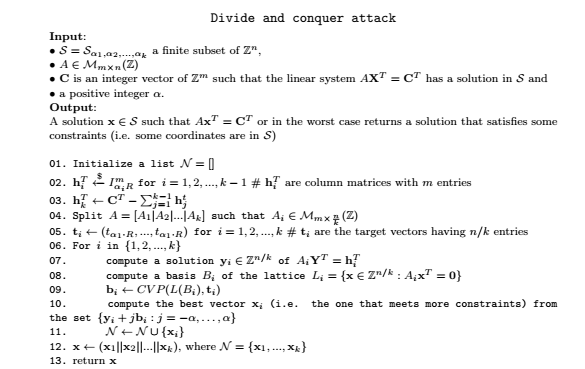


In [128]:
# Babai's Code



def babai(B,v):
    Y=[]
    i=0
    j=0
    row=int(B.nrows())
    col=int(B.ncols())
    w=vector([0 for i in range(0,len(v))])
    Gram=B.gram_schmidt()[0] # Gram_schmidt is a function of Sagemath
    w=vector(v)
    for j in range(row):        
        i=row-j-1
        c1=w.dot_product((Gram[i])) # dot product is a function of Sagemath
        c2=Gram[i].dot_product(Gram[i])
        l=c1/c2
        e=floor(l+0.5)*(B.row(i))
        Y.append(e)
        w=w-(l-floor(l+0.5))*Gram[i]-(floor(l+0.5)*B.row(i))   
    u=sum(Y)        
    return u

def babai(M,t):
    '''
    Babai's Nearest Plane Algorithm
    *Input : a basis of a lattice, given as a matrix M (the rows generates the lattice),                          
    the associated Gram-Schmidt basis matrix M_GS and a target vector t. 
    *Output :  an approximate closest vector to t
    '''
    M_GS = M.gram_schmidt()[0]
    w=vector(t)
    t=vector(t)
    for i in range(rank(M)-1,-1,-1):
        w = w - round((w.dot_product(M_GS[i]))/(M_GS[i].norm())^2)*M[i]
    return t - w


    


In [129]:
# target vectors

if index==1:
    t_R = 2^(R-1)+2^(R-2)                 
    target = vector([t_R]*n)

if index==2:
    t_R  = 2^(R-1)   +  2^(R-2)
    t_R2 = 2^(R/2-1) +  2^(R/2-2)
    target = vector([t_R]*int(n/2) + [t_R2]*int(n/2) )     

if index==3:
    t_R2  = 2^(R/2-1)   +  2^(R/2-2)
    t_R4 = 2^(R/4-1) +  2^(R/4-2)
    target = vector([t_R2]*int(n/2) + [t_R4]*int(n/2) )   
    
if index==4:
    t_R2 = 2^(R/2-1) + 2^(R/2-2)
    t_R4 = 2^(R/4-1) + 2^(R/4-2)
    t_R8 = 2^(R/8-1) + 2^(R/8-2)
    target = vector([t_R2]*int(n/3) + [t_R4]*int(n/3) + [t_R8]*int(n/3)) 
    

In [130]:
if string=='first_approach':
    if rank_of_L(A)[0]>1 and m>1: # we want at least two rows to apply LLL reduction to matrix A
        B_lll=basis.LLL() # before we execute Babai we reduce the basis with LLL or BKZ
    else:
        B_lll=A
#Alll=A.BKZ(block_size=35) # uncomment if you want to use BKZ

if string=='second_approach':
    if index==2 or index==3:
        if rank_of_L(A1)[0]>1 and m>1: # we want at least two rows to apply LLL reduction to matrix A
            B_lll1=basis.LLL(A1) # before we execute Babai we reduce the basis with LLL or BKZ
        if rank_of_L(A2)[0]>1 and m>1:
            B_lll2=basis.LLL(A2)
        if m==1:
            B_lll1 = basis1
            B_lll2 = basis2
    if index==4:
        if rank_of_L(A1)[0]>1 and m>1: # we want at least two rows to apply LLL reduction to matrix A
            B_lll1=basis.LLL(A1) # before we execute Babai we reduce the basis with LLL or BKZ
        if rank_of_L(A2)[0]>1 and m>1:
            B_lll2=basis.LLL(A2)
        if m==1:
            B_lll1 = basis1
            B_lll2 = basis2
            B_lll3 = basis3
        

In [131]:
#print("target:",target);
#print("B lll:");print(B_lll)

In [132]:
# We execute the attack
# First we execute approximate CVP using Babai's algorithm
if string=='first_approach':
    babai_vector=babai(B_lll,target)  
    babai_vector
if string=='second_approach':
    if index==2 or index==3:
        target1=target[:n/2]
        target2=target[n/2:]
        babai_vector1=babai(B_lll1,target1)
        babai_vector2=babai(B_lll2,target2)
        print((A1*matrix(babai_vector1).T)[0]==0)
        print((A2*matrix(babai_vector2).T)[0]==0)
    if index==4:
        target1=target[:n/3]
        target2=target[n/3:2*n/3]
        target3=target[2*n/3:]
        babai_vector1=babai(B_lll1,target1)
        babai_vector2=babai(B_lll2,target2)
        babai_vector3=babai(B_lll3,target3)
        print((A1*matrix(babai_vector1).T)[0]==0)
        print((A2*matrix(babai_vector2).T)[0]==0)
        print((A3*matrix(babai_vector3).T)[0]==0)

True
True


The last step of the attack is to construct vectors of the form
$${\bf v}_j = {\rm{sol}} + j\cdot {\rm babai\_vector}, j=-10,...,10 $$
To -10,10 επιλέχθηκε ευρετικά.
<br>
Αν το babai_vector είναι το μηδενικό διάνυσμα, αυτό σημαίνει ότι, το μηδενικο διάνυσμα είναι αυτό που είναι πιο
κοντά στο target. Σε αυτή την περίπτωση το ${\bf v}_j={\rm {sol}}$ για όλα τα $j.$

In [133]:
alpha = 20

if string=='first_approach': # indepedent from index
    Xdn=[]
    Xdp=[]
    Xd=[]
    if babai_vector!=vector([0]*n):
        Xdn = [vector(sol) -j*vector(babai_vector) for j in range(alpha)] #the vectors returned by CVP method
        Xdp = [vector(sol) + j*vector(babai_vector) for j in range(alpha)] #the vectors returned by CVP method 
        Xd = Xdn+Xdp
    else:
        Xd = vector(sol)
        alpha = 0
    #print(Xd)
if string=='second_approach' and k==2:  # indepedent from index

    Xdn1=[]
    Xdp1=[]
    Xd1=[]
    
    Xdn2=[]
    Xdp2=[]
    Xd2=[]
    if babai_vector1!=vector([0]*n):
        Xdn1 = [vector(sol1) - j*vector(babai_vector1) for j in range(alpha)] 
        Xdp1 = [vector(sol1) + j*vector(babai_vector1) for j in range(alpha)]
        Xd1 = Xdn1+Xdp1
    if babai_vector2!=vector([0]*n):
        Xdn2 = [vector(sol2) - j*vector(babai_vector2) for j in range(alpha)] 
        Xdp2 = [vector(sol2) + j*vector(babai_vector2) for j in range(alpha)]
        Xd2 = Xdn2+Xdp2
    if babai_vector1==vector([0]*n):
        Xd1 = vector(sol1)
        alpha = 0
    if babai_vector2==vector([0]*n):
        Xd2 = vector(sol2)
        alpha = 0
        
if string=='second_approach' and k==3:  # indepedent from index

    Xdn1=[]
    Xdp1=[]
    Xd1=[]
    
    Xdn2=[]
    Xdp2=[]
    Xd2=[]
    
    Xdn3=[]
    Xdp3=[]
    Xd3=[]
    if babai_vector1!=vector([0]*n):
        Xdn1 = [vector(sol1) - j*vector(babai_vector1) for j in range(alpha)] 
        Xdp1 = [vector(sol1) + j*vector(babai_vector1) for j in range(alpha)]
        Xd1 = Xdn1+Xdp1
    if babai_vector2!=vector([0]*n):
        Xdn2 = [vector(sol2) - j*vector(babai_vector2) for j in range(alpha)] 
        Xdp2 = [vector(sol2) + j*vector(babai_vector2) for j in range(alpha)]
        Xd2 = Xdn2+Xdp2
    if babai_vector3!=vector([0]*n):
        Xdn3= [vector(sol3) - j*vector(babai_vector3) for j in range(alpha)] 
        Xdp3= [vector(sol3) + j*vector(babai_vector3) for j in range(alpha)]
        Xd3= Xdn3+Xdp3
    if babai_vector1==vector([0]*n):
        Xd1 = vector(sol1)
        alpha = 0
    if babai_vector2==vector([0]*n):
        Xd2 = vector(sol2)
        alpha = 0
    if babai_vector3==vector([0]*n):
        Xd3 = vector(sol3)
        alpha = 0
    

In [134]:
def number_of_good_entries(list,upper,lower): #the number of entries in the intrval [lower,uppper]
        C=0
        for i in range(len(list)):
            if (list[i]<=upper and list[i]>=lower):
                C=C+1      
        return C,len(list)-C #number of good and bad entries, respecively

In [135]:
# we want to check if our attack found a vector in S1 or S2
if string=='first_approach':
    if index == 1:
        u = 2^R-1
        l = 2^(R-1)
        for i in range(2*alpha):
            C = [number_of_good_entries(list(Xd[i]),u,l)[0]]
            if C[0] == n:
                print("Success!")
                print("the solution:",Xd[i])
                break

    if index == 2:
        # R bits
        u1 = 2^R-1
        l1 = 2^(R-1)
        # R/2 bits
        u2 = 2^(R/2 - 1)
        l2 =  2^(R/2) - 1
        for i in range(2*alpha):
            C1 = [number_of_good_entries(list(Xd[i][:n/2]),u1,l1)[0]]
            C2 = [number_of_good_entries(list(Xd[i][n/2:]),u2,l2)[0]]
            print(Xd[i][n/2:])
            if C1[0] == n/2 and C2[0]==n/2:
                print("Success!")
                print("the solution:",Xd[i])
                break

    if index == 3:
        # R bits
        u1 = 2^R/2-1
        l1 = 2^((R/2)-1)
        # R/2 bits
        u2 = 2^(R/4) - 1
        l2 = 2^((R/4) - 1)
        if alpha!=0:
            for i in range(2*alpha):
                C1 = [number_of_good_entries(list(Xd[i][:n/2]),u1,l1)[0]]
                C2 = [number_of_good_entries(list(Xd[i][n/2:]),u2,l2)[0]]
                #print(Xd[i][n/2:])
                if C1[0] == n/2 and C2[0]==n/2:
                    print("Success!")
                    print("the solution:",Xd[i])
                    break
        else:
            C1 = [number_of_good_entries(list(Xd[:n/2]),u1,l1)[0]]
            C2 = [number_of_good_entries(list(Xd[n/2:]),u2,l2)[0]]
            #print(Xd[i][n/2:])
            if C1[0] == n/2 and C2[0]==n/2:
                print("Success!")
                print("the solution:",Xd)

    #C = [number_of_good_entries(list(Xd[i]),u,l)[0] for i in range(2*alpha)] 
    #if max(C)==n: # δηλ. αν βρήκα n συντεταγμένες μέσα στο I_R επιστρέφω "επιτυχία"
    #    print("Success!")


In [139]:
# we want to check if our attack found a vector in S1 or S2 or S3
if string=='second_approach':
    M1=[]
    M2=[]
    M3=[]
    if index == 2: # index = 2 --> S2
        u1 = 2^R-1
        l1 = 2^(R-1)
        u2 = 2^(R/2)-1
        l2 = 2^((R/2)-1)
        if alpha==0: # this is the case where babai returned the zero vector
            temp1 = number_of_good_entries(list(Xd1),u1,l1)
            C1 = temp1[0]
            M1.append(C1)
            temp2 = number_of_good_entries(list(Xd2),u2,l2)
            C2 = temp2[0]
            M2.append(C2)
        else:
            for i in range(2*alpha):
                temp1 = number_of_good_entries(list(Xd1[i]),u1,l1)
                C1 = temp1[0]
                M1.append(C1)
                temp2 = number_of_good_entries(list(Xd2[i]),u2,l2)
                C2 = temp2[0]
                M2.append(C2)
        print("max hits from first equation:",max(M1),"max hits from second equation:",max(M2))
        print( ( max(M1) + max(M2) ) / n * 100.)
        t1 = M1.index(max(M1))
        x1 = Xd1[t1]
        t2 = M2.index(max(M2))
        x2 = Xd2[t2]
        x=list(x1)+list(x2)
        print(A*matrix(x).T==matrix([b[0]]).T) # it is indeed a solution
        
    if index == 3: # index = 3 --> S3
        u1 = 2^(R/2)-1
        l1 = 2^((R/2)-1)
        u2 = 2^(R/4)-1
        l2 = 2^((R/4)-1)
        if alpha==0: # this is the case where babai returned the zero vector
            temp1 = number_of_good_entries(list(Xd1),u1,l1)
            C1 = temp1[0]
            M1.append(C1)
            temp2 = number_of_good_entries(list(Xd2),u2,l2)
            C2 = temp2[0]
            M2.append(C2)
        else:
            for i in range(2*alpha):
                temp1 = number_of_good_entries(list(Xd1[i]),u1,l1)
                C1 = temp1[0]
                M1.append(C1)
                temp2 = number_of_good_entries(list(Xd2[i]),u2,l2)
                C2 = temp2[0]
                M2.append(C2)        
        print("max hits from first equation:",max(M1),"max hits from second equation:",max(M2))
        print( ( max(M1) + max(M2) ) / n * 100.)
        t1 = M1.index(max(M1))
        x1 = Xd1[t1]
        t2 = M2.index(max(M2))
        x2 = Xd2[t2]
        x=list(x1)+list(x2)
        print(A*matrix(x).T==matrix([b[0]]).T) # it is indeed a solution
        
            
    if index == 4: # index = 4 --> S4
        u1 = 2^(R/2)-1
        l1 = 2^((R/2)-1)
        u2 = 2^(R/4)-1
        l2 = 2^((R/4)-1)
        u3 = 2^(R/8)-1
        l3= 2^((R/8)-1)
        
        if alpha==0: # this is the case where babai returned the zero vector
            temp1 = number_of_good_entries(list(Xd1),u1,l1)
            C1 = temp1[0]
            M1.append(C1)
            temp2 = number_of_good_entries(list(Xd2),u2,l2)
            C2 = temp2[0]
            M2.append(C2)
        else:
            for i in range(2*alpha):
                temp1 = number_of_good_entries(list(Xd1[i]),u1,l1)
                C1 = temp1[0]
                M1.append(C1)
                temp2 = number_of_good_entries(list(Xd2[i]),u2,l2)
                C2 = temp2[0]
                M2.append(C2)
                temp3 = number_of_good_entries(list(Xd3[i]),u3,l3)
                C3 = temp3[0]
                M3.append(C3)
        print("max hits from first equation:",max(M1),"max hits from second equation:",max(M2),max(M3))
        print( ( max(M1) + max(M2) + max(M3) ) / n * 100.)
        t1 = M1.index(max(M1))
        x1 = Xd1[t1]
        t2 = M2.index(max(M2))
        x2 = Xd2[t2]
        t3 = M3.index(max(M3))
        x3 = Xd3[t3]
        x=list(x1)+list(x2)+list(x3)
        print(A*matrix(x).T==matrix([b[0]]).T) # it is indeed a solution

max hits from first equation: 12 max hits from second equation: 3
62.5000000000000
True


In [137]:
A*matrix(x).T==matrix([b[0]]).T # it is indeed a solution

True

Παρακάτω στην ενότητα "Ιmprovement of step 3" δίνω τον αλγόριθμο από το paper 
<br>
Karen Aardal, Cor A. J. Hurkens and Arjen K. Lenstra, Solving a System of Linear Diophantine Equations with Lower and Upper Bounds on the Variables, Mathematics of Operations Research, Vol. 25, No.  3 (Aug., 2000), p. 427--442 (16 pages).	
<br>
Στο προηγούμενο paper οι συγγραφεις όταν γράφουν ότι ένα lattice παράγεται από τον πίνακα Α, εννοούνε ότι παράγεται από τις σηλες του πίνακα και όχι από τις γραμμές. Στον παρακάτω κώδικα, έχουμε θεωρήσει τον ανάστροφο επειδη το sagemath όταν κάνει LLL σε έναν πίνακα, κάνει στις γραμμές του. 

# <span style="color:purple">Ενοποιημένος Κώδικας 

In [1]:
reset()

# some auxiliary functions
def bits(n):
    return floor(log( max ( abs(n), 1) ,2))+1

def draz(n,a,a0,par):
    '''
    we use this code only if m=1
    '''
    
    r=0;
    zerom=matrix(QQ,1,[r for i in range(0, n)]); # part of the last row
    X=[par for i in range(0, n)];
    L=matrix(QQ,2,[[0 for i in range(0, n)],[a[i] for i in range(0, n)]]);
    L=L.transpose();
    M = identity_matrix(ZZ, n);
    M=matrix(QQ,n,[1/X[i]*M.row(i) for i in range(0,n)]);
    Mb=block_matrix([[M,L]]);
    zerom1=block_matrix([[zerom,1,-a0]]);  # this is the last row
    Mb1=Mb.stack(zerom1);#show(Mb1);
    #print(Mb1)
    L=Mb1.LLL();
    L1=[[(L[j][i]-r)*X[i] for i in range(0,n)] for j in range(0,n+1)];#if the last row has 1/2 instead of 0
    L2=[vector(L1[i]).dot_product(vector(a))-a0 for i in range(0,n+1)];
    if L2.count(0)>0:
        sol = L1[L2.index(0)]
        return sol,vector(sol).norm().n()
    else:
        return "NULL"   

###
# main code

def gen_A_and_x(R,n,m,index):
    '''
    R : bits
    n : dimension
    m : number of equations
    index = 1,2 or 3
    '''

        
    if index >6 or index<0:
        print("1<=index <=6")
        return _,_,_  
    if n%2==1:
        print("n must be even")
        return _,_,_
    if R%2==1:
        print("R must be even")
        return _,_,_
    if R%4 != 0 and index==3:
        print("R must be divisible by 4")
        return _,_,_
    if index==4:
        if R%8 != 0:
            print("R must be divisible by 8")
            return _,_,_
        if n % 3 != 0:
            print("n must be divisible by 3")
            return _,_,_
    if index==5:
        if R%8 != 0:
            print("R must be divisible by 8")
            return _,_,_
        if n % 4 != 0:
            print("n must be divisible by 4")
            return _,_,_
    if index==6:
        if R%16 != 0:
            print("R must be divisible by 16")
            return _,_,_
        if n % 5 != 0:
            print("n must be divisible by 5")
            return _,_,_
    
    # generation of a matrix with elements from I_{R/2}
    left  = 2^(R/2-1)
    right = 2^(R/2) - 1
    
    # generation of a matrix with elements from I_{R}
    left  = 2^(R-1)
    right = 2^(R) - 1
        
    # generation of a matrix with elements from I_{R/8}
    left  = 2^(R/8-1)
    right = 2^(R/8) - 1


    # Now, we generate a matrix with (n-1) rows, and random integer elements from the interval [left, right]
    A = matrix( [vector([ZZ.random_element(left,right+1) for _ in range(n)]) for _  in range(m)] )
    if index == 1:
        left1  = 2^(R-1)
        right1 = 2^R - 1
        x = vector([ZZ.random_element(left1 , right1 + 1) for _ in range(n)])

    if index == 2:
        left1   = 2^(R-1)
        right1  = 2^R - 1
        left2   = 2^(R/2 - 1)
        right2  = 2^(R/2) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/2)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/2)]
        x = vector(x1+x2)
    
    if index == 3:
        left1   = 2^(R/2-1)
        right1  = 2^(R/2) - 1
        left2   = 2^(R/4 - 1)
        right2  = 2^(R/4) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/2)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/2)]
        x = vector(x1+x2)
        
    if index == 4:
        left1   = 2^(R/2-1)
        right1  = 2^(R/2) - 1
        left2   = 2^(R/4 - 1)
        right2  = 2^(R/4) - 1
        left3   = 2^(R/8 - 1)
        right3  = 2^(R/8) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/3)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/3)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/3)]
        x = vector(x1+x2+x3)
        
    if index == 5:
        left1   = 2^(R-1)
        right1  = 2^(R) - 1
        left2   = 2^(R/2 - 1)
        right2  = 2^(R/2) - 1
        left3   = 2^(R/4 - 1)
        right3  = 2^(R/4) - 1
        left4   = 2^(R/8 - 1)
        right4  = 2^(R/8) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/4)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/4)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/4)]
        x4 = [ZZ.random_element(left4 , right4 + 1) for _ in range(n/4)]
        x = vector(x1+x2+x3+x4)

    if index == 6:
        left1   = 2^(R-1)
        right1  = 2^(R) - 1
        left2   = 2^(R/2 - 1)
        right2  = 2^(R/2) - 1
        left3   = 2^(R/4 - 1)
        right3  = 2^(R/4) - 1
        left4   = 2^(R/8 - 1)
        right4  = 2^(R/8) - 1
        left5   = 2^(R/16 - 1)
        right5  = 2^(R/16) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/5)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/5)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/5)]
        x4 = [ZZ.random_element(left4 , right4 + 1) for _ in range(n/5)]
        x5 = [ZZ.random_element(left5 , right5 + 1) for _ in range(n/5)]
        x = vector(x1+x2+x3+x4+x5)
    #print("secret key x:",x)
    # we compute also the vector b
    b = (A*x) # όταν το m=1 απλα υπολογιζουμε το εσωτερικό γινόμενο
    #print("b:",b)
    return A,x,b

#rank of the lattice
def rank_of_L(A):
    '''
    outputs three integers. 
    [1] the rank of the lattice Ax=0, which is equal to (number of columns of A)-(rank(A)), 
    This is in fact the dimension of the nullspace(A).
    [2] the number of columns k and 
    [3] the rank r of A
    '''
    k=A.dimensions()[1] # number of columns
    r=A.rank()
    return k-r,k,r

#basis of the lattice L:ΑΧ=0
def kernel(B):
    A = matrix(ZZ,B)
    Rank,k,r = rank_of_L(A)
    #print("rank of the lattice:",Rank ) # αυτό είναι απο το θεώρημα της διάστασης.
    Q=A.smith_form()[2]
    X=matrix(ZZ,[Q.column(i) for i in range(r,k)])
    return X

'''
input   : dimension n, a vector a = [a1,a2,...,an], a target integer b 
          and a parameter Y which represents a bound for the solution, i.e. 
          we search for solutions |x_i|<Y. So choose Y large.
          
output  : a solution of the equation a1x1+a2x2+...+anxn=b, possibly satisfies |xi|<Y

'''
def a_solution(n,a,b,Y):    
    r=0;    
    #construction of the matrix
    zerom=matrix(QQ,1,[r for i in range(0, n)]); # part of the last row
    X=[Y for i in range(0, n)];
    L=matrix(QQ,2,[[0 for i in range(0, n)],[a[i] for i in range(0, n)]]);
    L=L.transpose();
    M = identity_matrix(ZZ, n);
    M=matrix(QQ,n,[1/X[i]*M.row(i) for i in range(0,n)]);
    Mb=block_matrix([[M,L]]);
    zerom1=block_matrix([[zerom,1,-b]]);  # this is the last row
    Mb1=Mb.stack(zerom1);
    
    L=Mb1.LLL();   #use LLL algorithm for basis reduction
    L1=[[(L[j][i]-r)*X[i] for i in range(0,n)] for j in range(0,n+1)];#if the last row has 1/2 instead of 0
    L2=[vector(L1[i]).dot_product(vector(a))-b for i in range(0,n+1)];
    if L2.count(0)>0:
        print("Euclidean length of the solution:",float(vector(L1[L2.index(0)]).norm()))
        print("One solution is:",L1[L2.index(0)])
        return L1[L2.index(0)]
    else:
        print("NULL")
        return "NULL"


def construction_of_matrix(A,d,N1,N2):

    '''
    input   : dimension n, a matrix mxn A = [aij], a column vector d
              and two parameters N1, N2 with N1<N2

    output  : a solution of the system Ax=d

    '''

    # we define the rows (m) and columns (n)
    n,m=A.dimensions()[1] , A.dimensions()[0]
    # construction of the matrix
    zerom1 = matrix(QQ,1,[0 for i in range(0, n)]).T;     # 0_{nx1}
    zerom2 = matrix(QQ,1,[0 for i in range(0, n)]+[N1]);  # [0_{1xn},N1]
    In = identity_matrix(ZZ, n);
    upper_block = block_matrix([[In,zerom1]]);
    medium_row = zerom2
    lower_block = block_matrix([[N2*A,-N2*d]]);
    final_matrix = block_matrix(3,[ [upper_block], [zerom2], [lower_block]])
    return final_matrix.T


def a_solution_of_the_system(A,d,N1,N2):
    if A==_:
        return
    B=construction_of_matrix(A,d,N1,N2)
    Blll = B.LLL()
    #in order to find the solutions
    # you have to find the row that has the entry N1 i.e.
    # we are looking for a row of the form (....,N1,...)

    nrows = Blll.dimensions()[0]
    for i in range(nrows):
        if N1 in Blll.row(i):
            t = i
            solution = Blll.row(t)[:n]
            #print("solution:",solution)
            return solution
    print("error")
    return "error"



def babai(B,v):
    Y=[]
    i=0
    j=0
    row=int(B.nrows())
    col=int(B.ncols())
    w=vector([0 for i in range(0,len(v))])
    Gram=B.gram_schmidt()[0] # Gram_schmidt is a function of Sagemath
    w=vector(v)
    for j in range(row):        
        i=row-j-1
        c1=w.dot_product((Gram[i])) # dot product is a function of Sagemath
        c2=Gram[i].dot_product(Gram[i])
        l=c1/c2
        e=floor(l+0.5)*(B.row(i))
        Y.append(e)
        w=w-(l-floor(l+0.5))*Gram[i]-(floor(l+0.5)*B.row(i))   
    u=sum(Y)        
    return u

def Xd_list(alpha,babai_vector,sol):
    '''
    input  : an integer alpha, usually 10 and the output of babai(.,.)
    output : a list that contains the vectors, sol +j*babai_vector, for j=-alpha,...,alpha 
    '''
    Xdn=[]
    Xdp=[]
    Xd=[]
    if babai_vector!=vector([0]*n):
        Xdn = [vector(sol) - j*vector(babai_vector) for j in range(alpha)] #the vectors returned by CVP method
        Xdp = [vector(sol) + j*vector(babai_vector) for j in range(alpha)] #the vectors returned by CVP method 
        Xd = Xdn+Xdp
    else: # i.e. in the case where babai provides the zero vector
        Xd = vector(sol)
        alpha = 0
    return Xd,alpha

def number_of_good_entries(list,upper,lower): #the number of entries in the intrval [lower,uppper]
        C=0
        for i in range(len(list)):
            if (list[i]<=upper and list[i]>=lower):
                C=C+1      
        return C,len(list)-C #number of good and bad entries  

def number_of_good_entries2(list,upper,lower,upper1,lower1): 
    #the number of entries in the interval [lower1,uppper1] for the first n/2 coordinates of 'list'
    #and in [lower2,upper2] for the rest n/2 coordinates of the element of 'list'.
        C=0
        for i in range(len(list)):
            if (list[i]<=upper and list[i]>=lower) or (list[i]<=upper1 and list[i]>=lower1):
                C=C+1      
        return C,len(list)-C #number of good and bad entries 
    
def number_of_good_entries3(list,upper,lower,upper1,lower1,upper2,lower2): 
    #the number of entries in the interval [lower1,uppper1] for the first n/2 coordinates of 'list'
    #and in [lower2,upper2] for the rest n/2 coordinates of the element of 'list'.
        C=0
        for i in range(len(list)):
            if (list[i]<=upper and list[i]>=lower) or (list[i]<=upper1 and list[i]>=lower1) or (list[i]<=upper2 and list[i]>=lower2):
                C=C+1      
        return C,len(list)-C #number of good and bad entries 
    
def number_of_good_entries4(list,upper,lower,upper1,lower1,upper2,lower2,upper3,lower3): 
    #the number of entries in the interval [lower1,uppper1] for the first n/2 coordinates of 'list'
    #and in [lower2,upper2] for the rest n/2 coordinates of the element of 'list'.
        C=0
        for i in range(len(list)):
            if (list[i]<=upper and list[i]>=lower)\
            or (list[i]<=upper1 and list[i]>=lower1)\
            or (list[i]<=upper2 and list[i]>=lower2)\
            or (list[i]<=upper3 and list[i]>=lower3):
                C=C+1      
        return C,len(list)-C #number of good and bad entries 
    
def number_of_good_entries5(list,upper,lower,upper1,lower1,upper2,lower2,upper3,lower3,upper4,lower4): 
    #the number of entries in the interval [lower1,uppper1] for the first n/2 coordinates of 'list'
    #and in [lower2,upper2] for the rest n/2 coordinates of the element of 'list'.
        C=0
        for i in range(len(list)):
            if (list[i]<=upper and list[i]>=lower)\
            or (list[i]<=upper1 and list[i]>=lower1)\
            or (list[i]<=upper2 and list[i]>=lower2)\
            or (list[i]<=upper3 and list[i]>=lower3)\
            or (list[i]<=upper4 and list[i]>=lower4):
                C=C+1      
        return C,len(list)-C #number of good and bad entries 

In [2]:
# we want to check if our attack finds a vector in S1 or S2
# some auxiliary functions
def bits(n):
    return floor(log( max ( abs(n), 1) ,2))+1

def rank_of_matrix(C):
    B=C.echelon_form()
    zero_list = [0]*B.dimensions()[1]
    num_rows = B.dimensions()[0]
    upper = 0
    lower = num_rows
    while(abs(lower-upper)!=1):
        mean = floor((upper+lower)/2)
        if B[mean] != vector(zero_list):
            upper=  mean
        else:
            if B[mean+1] == vector(zero_list):
                lower = mean
    return max(lower,upper)


def generate_idempotent(N,k):
    # N is the dimension of the matrix
    # k is used to get an upper bound of the entries : 2^k
    from sage.matrix.constructor import random_subspaces_matrix
    from sage.matrix.constructor import random_unimodular_matrix
    matrix_space = sage.matrix.matrix_space.MatrixSpace(ZZ,N)
    M = matrix(ZZ,N)
    D = identity_matrix(N)
    while D==0 or D==1:
        D = diagonal_matrix([ZZ.random_element(0,2) for _ in range(N)])
    #A = random_matrix(ZZ, N,N, algorithm='echelonizable', rank=N) # unimodular
    A = random_unimodular_matrix(matrix_space, upper_bound = 2**k)
    M = A*D*A^(-1)
    #print(D)
    print("max/min bits on entries:",max_min_bits(M))
    return M

def max_min_bits(A):
    # A is a rectangular matrix
    # return the max(bits(A[i,j])) and min(bits(A[i,j]))
    n = A.dimensions()[0]
    L = [ bits(A[i,j]) for i in range(n) for j in range(n)]
    return max(L),min(L)

def attack(A,sol,R,n,index,alpha1):
        
    if index >6 or index<0:
        return "Error"  
    if n%2==1:
        return "n must be even"
    if R%2==1:
        return "R must be even"
    if R%4 != 0 and index==3:
        return "R must be divisible by 4"
    
    basis = kernel(A)
    if index==1:
        t_R = 2^(R-1)+2^(R-2)
        target = vector([t_R]*n)
    
    if index==2:
        t_R  = 2^(R-1)   +  2^(R-2)
        t_R2 = 2^(R/2-1) +  2^(R/2-2)
        target = vector([t_R]*int(n/2) + [t_R2]*int(n/2) )
    
    if index==3:
        t_R2 = 2^(R/2-1) + 2^(R/2-2)
        t_R4 = 2^(R/4-1) + 2^(R/4-2)
        target = vector([t_R2]*int(n/2) + [t_R4]*int(n/2) )  
        #print("target:",target)
        
    if index==4:
        t_R2 = 2^(R/2-1) + 2^(R/2-2)
        t_R4 = 2^(R/4-1) + 2^(R/4-2)
        t_R8 = 2^(R/8-1) + 2^(R/8-2)
        target = vector([t_R2]*int(n/3) + [t_R4]*int(n/3) + [t_R8]*int(n/3)) 
    
    if index==5:
        t_R  = 2^(R-1)   +  2^(R-2)
        t_R2 = 2^(R/2-1) + 2^(R/2-2)
        t_R4 = 2^(R/4-1) + 2^(R/4-2)
        t_R8 = 2^(R/8-1) + 2^(R/8-2)
        target = vector( [t_R]*int(n/4) + [t_R2]*int(n/4) + [t_R4]*int(n/4) + [t_R8]*int(n/4)) 
        
    if index==6:
        t_R  = 2^(R-1)   +  2^(R-2)
        t_R2 = 2^(R/2-1) + 2^(R/2-2)
        t_R4 = 2^(R/4-1) + 2^(R/4-2)
        t_R8 = 2^(R/8-1) + 2^(R/8-2)
        t_R16 = 2^(R/16-1) + 2^(R/16-2)
        target = vector( [t_R]*int(n/5) + [t_R2]*int(n/5) + [t_R4]*int(n/5) + [t_R8]*int(n/5) + [t_R16]*int(n/5)) 

    if rank_of_L(A)[0]>1: # we want at least two rows to apply LLL reduction to matrix A
        B_lll=basis.LLL() # before we execute Babai we reduce the basis with LLL or BKZ
    else:
        B_lll=A # λαθος Β_ll=basis
    #Alll=A.BKZ(block_size=35) # uncomment if you want to use BKZ
    
    # We execute the attack
    # First we execute approximate CVP using Babai's algorithm
    babai_vector=babai(B_lll,target)          
    Xd,alpha=Xd_list(alpha1,babai_vector,sol)
    
    if index == 1:
        u = 2^R-1
        l = 2^(R-1)
        
        if alpha==0: # this is the case where babai returned the zero vector
            temp = number_of_good_entries(list(Xd),u,l)
            C = temp[0]
            return C
            
        M = []
        for i in range(2*alpha):
            temp = number_of_good_entries(list(Xd[i]),u,l)
            C = temp[0]
            M.append(C)
        return max(M)

    if index == 2:
        # R bits
        u1 = 2^R-1
        l1 = 2^(R-1)
        # R/2 bits
        u2 =  2^(R/2) - 1
        l2 = 2^(R/2 - 1)
        
        if alpha==0: # this is the case where babai returned the zero vector
            temp = number_of_good_entries2(list(Xd),u1,l1,u2,l2)
            C = temp[0]
            return C
        
        M = []
        for i in range(2*alpha):
            temp = number_of_good_entries2(list(Xd[i]),u1,l1,u2,l2)
            C = temp[0]
            M.append(C)
        return max(M)
    
    if index == 3:
        # R bits
        u1 = 2^(R/2)-1
        l1 = 2^(R/2-1)
        # R/2 bits
        u2 =  2^(R/4) - 1
        l2 = 2^(R/4 - 1)
        #print(u1,l1,",",u2,l2)
        if alpha==0: # this is the case where babai returned the zero vector
            temp = number_of_good_entries2(list(Xd),u1,l1,u2,l2)
            C = temp[0]
            return C
        
        M=[]
        for i in range(2*alpha):
            temp = number_of_good_entries2(list(Xd[i]),u1,l1,u2,l2)
            C = temp[0]
            #print(Xd[i],Xd[i][:n/2],C)
            #print(temp,C)
            M.append(C)
        return max(M)
            #if C == n:
            #    return("Success!")
    
    if index == 4:
        # R/2 bits
        u1 = 2^(R/2)-1
        l1 = 2^(R/2-1)
        # R/4 bits
        u2 =  2^(R/4) - 1
        l2 = 2^(R/4 - 1)
        # R/8 bits
        u3 =  2^(R/8) - 1
        l3 = 2^(R/8 - 1)
        
        if alpha==0: # this is the case where babai returned the zero vector
            temp = number_of_good_entries3(list(Xd),u1,l1,u2,l2,u3,l3)
            C = temp[0]
            return C
        
        M=[]
        for i in range(2*alpha):
            temp = number_of_good_entries3(list(Xd[i]),u1,l1,u2,l2,u3,l3)
            C = temp[0]
            M.append(C)
        return max(M)

    if index == 5:
        # R bits
        u1 = 2^R-1
        l1 = 2^(R-1)
        # R/2 bits
        u2 =  2^(R/2) - 1
        l2 = 2^(R/2 - 1)
        # R/4 bits
        u3 =  2^(R/4) - 1
        l3 = 2^(R/4 - 1)
        # R/8 bits
        u4 =  2^(R/8) - 1
        l4 = 2^(R/8 - 1)
        
        if alpha==0: # this is the case where babai returned the zero vector
            temp = number_of_good_entries4(list(Xd),u1,l1,u2,l2,u3,l3,u4,l4)
            C = temp[0]
            return C
        
        M=[]
        for i in range(2*alpha):
            temp = number_of_good_entries4(list(Xd[i]),u1,l1,u2,l2,u3,l3,u4,l4)
            C = temp[0]
            M.append(C)
        return max(M)

    if index == 6:
        # R bits
        u1 = 2^R-1
        l1 = 2^(R-1)
        # R/2 bits
        u2 =  2^(R/2) - 1
        l2 = 2^(R/2 - 1)
        # R/4 bits
        u3 =  2^(R/4) - 1
        l3 = 2^(R/4 - 1)
        # R/8 bits
        u4 =  2^(R/8) - 1
        l4 = 2^(R/8 - 1)
        # R/16 bits
        u5 =  2^(R/16) - 1
        l5 = 2^(R/16 - 1)
        if alpha==0: # this is the case where babai returned the zero vector
            temp = number_of_good_entries5(list(Xd),u1,l1,u2,l2,u3,l3,u4,l4,u5,l5)
            C = temp[0]
            return C
        
        M=[]
        for i in range(2*alpha):
            temp = number_of_good_entries5(list(Xd[i]),u1,l1,u2,l2,u3,l3,u4,l4,u5,l5)
            C = temp[0]
            M.append(C)
        return max(M)

In [3]:
def gen_idempotent_A_x(R,n,index):
    '''
    n : dimension of the matrix A
    R : we estimate that the entries of the output will be ~2*K bits
    index = 1,2,3,4,5,6
    ''' 
    if index >6 or index<0:
        print("1<=index <=6")
        return _,_,_  
    if n%2==1:
        print("n must be even")
        return _,_,_
    if R%2==1:
        print("R must be even")
        return _,_,_
    if R%4 != 0 and index==3:
        print("R must be divisible by 4")
        return _,_,_
    if index==4:
        if R%8 != 0:
            print("R must be divisible by 8")
            return _,_,_
        if n % 3 != 0:
            print("n must be divisible by 3")
            return _,_,_
    if index==5:
        if R%8 != 0:
            print("R must be divisible by 8")
            return _,_,_
        if n % 4 != 0:
            print("n must be divisible by 4")
            return _,_,_
    if index==6:
        if R%16 != 0:
            print("R must be divisible by 16")
            return _,_,_
        if n % 5 != 0:
            print("n must be divisible by 5")
            return _,_,_
    
    # generation of a matrix with elements from I_{R/2}
    left  = 2^(R/2-1)
    right = 2^(R/2) - 1
    
    # generation of a matrix with elements from I_{R}
    left  = 2^(R-1)
    right = 2^(R) - 1
        
    # generation of a matrix with elements from I_{R/8}
    left  = 2^(R/8-1)
    right = 2^(R/8) - 1
    
    

    # Now, we generate an idempotent matrix
    #A = matrix( [vector([ZZ.random_element(left,right+Integer(1)) for _ in range(n)]) for _  in range(m)] )
    A = generate_idempotent(n,R)
    if index == 1:
        left1  = 2^(R-1)
        right1 = 2^R - 1
        x = vector([ZZ.random_element(left1 , right1 + 1) for _ in range(n)])

    if index == 2:
        left1   = 2^(R-1)
        right1  = 2^R - 1
        left2   = 2^(R/2 - 1)
        right2  = 2^(R/2) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/2)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/2)]
        x = vector(x1+x2)
    
    if index == 3:
        left1   = 2^(R/2-1)
        right1  = 2^(R/2) - 1
        left2   = 2^(R/4 - 1)
        right2  = 2^(R/4) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/2)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/2)]
        x = vector(x1+x2)
        
    if index == 4:
        left1   = 2^(R/2-1)
        right1  = 2^(R/2) - 1
        left2   = 2^(R/4 - 1)
        right2  = 2^(R/4) - 1
        left3   = 2^(R/8 - 1)
        right3  = 2^(R/8) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/3)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/3)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/3)]
        x = vector(x1+x2+x3)
        
    if index == 5:
        left1   = 2^(R-1)
        right1  = 2^(R) - 1
        left2   = 2^(R/2 - 1)
        right2  = 2^(R/2) - 1
        left3   = 2^(R/4 - 1)
        right3  = 2^(R/4) - 1
        left4   = 2^(R/8 - 1)
        right4  = 2^(R/8) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/4)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/4)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/4)]
        x4 = [ZZ.random_element(left4 , right4 + 1) for _ in range(n/4)]
        x = vector(x1+x2+x3+x4)

    if index == 6:
        left1   = 2^(R-1)
        right1  = 2^(R) - 1
        left2   = 2^(R/2 - 1)
        right2  = 2^(R/2) - 1
        left3   = 2^(R/4 - 1)
        right3  = 2^(R/4) - 1
        left4   = 2^(R/8 - 1)
        right4  = 2^(R/8) - 1
        left5   = 2^(R/16 - 1)
        right5  = 2^(R/16) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/5)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/5)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/5)]
        x4 = [ZZ.random_element(left4 , right4 + 1) for _ in range(n/5)]
        x5 = [ZZ.random_element(left5 , right5 + 1) for _ in range(n/5)]
        x = vector(x1+x2+x3+x4+x5)
    #print("secret key x:",x)
    # we compute also the vector b
    b = (A*x) # όταν το m=1 απλα υπολογιζουμε το εσωτερικό γινόμενο
    #print("b:",b)
    print("rank:", rank_of_matrix(A) )
    return A,x,b

In [4]:
def attack_instances(R,n,m,index,count,method):
    '''
    R,n,m,index : defined as previous
    count       : number of instances 
    method      : is a string, 'idempotent' or 'random'    
    '''
    
    import numpy as np
    H = []
    if method == 'idempotent':
        if n!=m:
            print("n,m must be equal in this specific case")
            return
        for i in range(count):
            print(i+1,".","generating idempotent matrix...")
            A,x,b= gen_idempotent_A_x(R,n,index)
            Ν1,Ν2=int(2^R),int(2^(R+2))
            alpha1 = 50
            sol = a_solution_of_the_system(A,matrix(b).T,Ν1,Ν2)
            hits = attack(A,sol,R,n,index,alpha1)
            H.append(hits)
            
    if method == 'random':
        for i in range(count):
            A,x,b = gen_A_and_x(R,n,m,index)
            Ν1,Ν2=int(2^R),int(2^(R+2))
            alpha1 = 50
            sol = a_solution_of_the_system(A,matrix(b).T,Ν1,Ν2)
            hits = attack(A,sol,R,n,index,alpha1)
            H.append(hits)
    print       
    print("unknowns=",n)
    print("equations=",m)
    print("number of instances considered:",count)
    print("average number of good hits:","{:.2f}".format(round(np.mean(H),2)),",","percentage :",float(100*np.mean(H)/n))
    print("the minumum of succeded hits:",min(H))
    print("the maximum :",max(H),",","percentage :",float(100*max(H)/n))
    if max(H)==n:
        print("+++ We found at least one solution +++")
    
    return 


In [268]:
R,n,m,index,method = 40,42,42,3,'idempotent'
count = 2
attack_instances(R,n,m,index,count,method)

1 . generating idempotent matrix...
max/min bits on entries: (86, 33)
rank: 21
2 . generating idempotent matrix...
max/min bits on entries: (98, 36)
rank: 16
unknowns= 42
equations= 42
number of instances considered: 2
average number of good hits: 21.00 , percentage : 50.0
the minumum of succeded hits: 21
the maximum : 21 , percentage : 50.0


# <span style="color:red">ΠΑΡΑΡΤΗΜΑΤΑ

# [1] Improvement of step 3
First, we need a more general algorithm for step **3**. I.e. an algorithm that works also for $m>1$.
<br>
Step **[3++]** is the more general algorithm, i.e. for more than one equation.

In [45]:
reset() # after reset we forget any variable we have used
def construction_of_matrix(A,d,N1,N2):
    # we define the rows (m) and columns (n)
    n,m=A.dimensions()[1] , A.dimensions()[0]
    # construction of the matrix
    zerom1 = matrix(QQ,1,[0 for i in range(0, n)]).T;     # 0_{nx1}
    zerom2 = matrix(QQ,1,[0 for i in range(0, n)]+[N1]);  # [0_{1xn},N1]
    In = identity_matrix(ZZ, n);
    upper_block = block_matrix([[In,zerom1]]);
    medium_row = zerom2
    lower_block = block_matrix([[N2*A,-N2*d]]);
    final_matrix = block_matrix(3,[ [upper_block], [zerom2], [lower_block]])
    return final_matrix.T

def a_solution_of_the_system(A,d,N1,N2):
    B=construction_of_matrix(A,d,N1,N2)
    Blll = B.LLL()
    t = n-m+1
    print(Blll)
    solution = Blll.row(t-1)[:n]
    print("solution:",solution)
    return solution
    

In [46]:
A = matrix([ [2,7,1] , [1,1,1] ])
print("matrix:")
print(A,"\n")
d = matrix( [57,14] ).T
print("d:",vector(d),"\n")
N1,N2=10,10000
n,m=A.dimensions()[1] , A.dimensions()[0]
B=construction_of_matrix(A,d,10,10000)
solution = a_solution_of_the_system(A,d,N1,N2)

matrix:
[2 7 1]
[1 1 1] 

d: (57, 14) 

[    -6      1      5      0      0      0]
[     7      6      1     10      0      0]
[    -1      0      1      0 -10000      0]
[    -1      0      2      0      0  10000]
solution: (7, 6, 1)


In [47]:
# Επαλήθευση
A*matrix(solution).T

[57]
[14]

Το παρακάτω παράδειγμα είναι απο το (προηγούμενο) paper

In [48]:
A = matrix([ [6,1,3,3,0,0],[0,0,0,0,2,1],[0,0,4,1,0,2]  ] )
d = matrix([17,11,27]).T
N1,N2=10,10000
n,m=A.dimensions()[1] , A.dimensions()[0]

In [49]:
A

[6 1 3 3 0 0]
[0 0 0 0 2 1]
[0 0 4 1 0 2]

In [50]:
B=construction_of_matrix(A,d,N1,N2)
B

[      1       0       0       0       0       0|      0|  60000       0       0]
[      0       1       0       0       0       0|      0|  10000       0       0]
[      0       0       1       0       0       0|      0|  30000       0   40000]
[      0       0       0       1       0       0|      0|  30000       0   10000]
[      0       0       0       0       1       0|      0|      0   20000       0]
[      0       0       0       0       0       1|      0|      0   10000   20000]
[      0       0       0       0       0       0|     10|-170000 -110000 -270000]

In [51]:
solution = a_solution_of_the_system(A,d,10,1000)

[   0   -3    1    0    1   -2    0    0    0    0]
[   1   -3   -1    0   -1    2    0    0    0    0]
[   1    0    2   -4    1   -2    0    0    0    0]
[   0   -1    5    1    4    3   10    0    0    0]
[   0    1    0    0    0    0    0 1000    0    0]
[   0    0   -1    1   -1    2    0    0    0 1000]
[   1    0    0   -2    0    1    0    0 1000    0]
solution: (0, -1, 5, 1, 4, 3)


In [52]:
# Επαλήθευση
A*matrix(solution).T

[17]
[11]
[27]

## [2] Πως να χρησιμοποιήσω το fpylll από το SageMath
(αγνοησε το προς το παρών)

In [73]:
reset()

from fpylll.util import set_random_seed,ball_log_vol,gaussian_heuristic
from fpylll.fplll.gso import MatGSO
import numpy as np
from fpylll import IntegerMatrix,LLL
import gmpy2
from fpylll import GSO


def fptosage(A):
    n = A.nrows
    C = matrix(n)
    for i in range(n):
        C[i] = list(A[i])
    return C

def sagemat2fp(A):
    from fpylll import IntegerMatrix
    r,c=A.dimensions()[0],A.dimensions()[1]
    L = IntegerMatrix(r,c)
    for i in range(r):
        for j in range(c):
            L[i,j] = int(A[i,j])
    return L

# converts from type fpylll.integetMatrix to numpy.array
def fp2mat(A):
    L = np.zeros(shape=(A.nrows, A.ncols))
    for i in range(A.nrows):
        for j in range(A.ncols):
            L[i, j] = int(A[i, j])
            L = np.array(L).astype(int)
    return L


In [74]:
A = matrix([ [10987239847,-2234234,34535],[3452344,234234,345345],[23434,454,4565] ])
show(A)

[10987239847    -2234234       34535]
[    3452344      234234      345345]
[      23434         454        4565]

In [75]:
B = sagemat2fp(A)
show(B)

<IntegerMatrix(3, 3) at 0x7f70b8e9a450>

In [76]:
LLL.reduction(B, delta =0.99 )
show(B)

<IntegerMatrix(3, 3) at 0x7f70b8e9a450>

In [77]:
M_GSO = GSO.Mat(B)
M_GSO.update_gso()

True

In [78]:
L = M_GSO.babai([1234234324,2234234223432456,-23433])

In [79]:
L

(2248310127, 2861658398, -1705724)

In [80]:

def LLL_reduction_of_M_NTRU(init_M_NTRU):        
    def fptosage(A):
        n = A.nrows
        C = matrix(n)
        for i in range(n):
            C[i] = list(A[i])
        return C
    import time
    from fpylll import IntegerMatrix,LLL
    start = time.time()
    M_NTRU_fplll = IntegerMatrix.from_matrix(init_M_NTRU)
    LLL.reduction(M_NTRU_fplll, delta =0.99 )
    M_NTRU = fptosage(M_NTRU_fplll)
    print("LLL is done")
    print("time for LLL:"),time.time()-start
    return M_NTRU,M_NTRU_fplll 

In [81]:

def volume_of_unit_sphere(n): # volume of n-sphere of radius 1
    return np.exp(ball_log_vol(n))

def volume_of_sphere(R,n):  # volume of n-sphere of radius R
    return R**n * volume_of_unit_sphere(n)

def gh(gram_matrix,par): #norm of the shortest vector given by GH 
    return par * np.sqrt(gaussian_heuristic(gram_matrix))

def limits(gram):
    return [gh(gram,0.95),gh(gram,1.05)]

def volume_of_lattice(A): #only sagemath. A is the basis matrix.
    return det(A*A.T).sqrt().n()
    
    
def volume_of_lattice_ver2(gram): 
    #returns the volume of a lattice as float not integer (use sagemath instead)
    grampfr=[]
    for i in range(len(gram)):
        grampfr.append(gmpy2.mpfr(gram[i]))
    log_volume = sum(gmpy2.log(grampfr_)/2 for grampfr_ in grampfr)
    return gmpy2.exp(log_volume)

def hf(gram): #Hermite's Factor of a lattice (for the vector ||b1||)
    from fpylll.tools.quality import basis_quality
    dim = len(gram)
    r0 = gram[0]
    log_volume = sum(np.log(r_)/2 for r_ in gram)
    return np.exp((np.log(r0)/2.0 - log_volume/dim)/dim)



In [82]:
def construction_of_matrix(A,d,N1,N2):
    # we define the rows (m) and columns (n)
    n,m=A.dimensions()[1] , A.dimensions()[0]
    # construction of the matrix
    zerom1 = matrix(QQ,1,[0 for i in range(0, n)]).T;     # 0_{nx1}
    zerom2 = matrix(QQ,1,[0 for i in range(0, n)]+[N1]);  # [0_{1xn},N1]
    In = identity_matrix(ZZ, n);
    upper_block = block_matrix([[In,zerom1]]);
    medium_row = zerom2
    lower_block = block_matrix([[N2*A,-N2*d]]);
    final_matrix = block_matrix(3,[ [upper_block], [zerom2], [lower_block]])
    return final_matrix.T

In [83]:
import copy
A = matrix([ [2,7,1] , [1,1,2], [1,2,3] ])
print("matrix:")
print(A,"\n")
d = matrix( [57,14,1] ).T
print("d:",vector(d),"\n")
N1,N2=1,1
B=construction_of_matrix(A,d,N1,N2)
print(B)
C=copy.copy(B)
n = B.dimensions()[0]
B=sagemat2fp(B)
B=LLL.reduction(B)
M = GSO.Mat(B)
M.update_gso()
gram = np.array([M.get_r(k,k) for k in range(n)])

volume_of_lattice_ver2(gram)

matrix:
[2 7 1]
[1 1 2]
[1 2 3] 

d: (57, 14, 1) 

[  1   0   0|  0|  2   1   1]
[  0   1   0|  0|  7   1   2]
[  0   0   1|  0|  1   2   3]
[  0   0   0|  1|-57 -14  -1]


mpfr('409.40933062156768')

## [3] Γιατι η Smith form είναι κατάλληλη για την εύρεση βάσης στο lattice ΑΧ=0;


In [29]:
#basis of the lattice L:ΑΧ=0
def kernel(A):
    k=A.dimensions()[1] # number of columns
    r=A.rank()
    print("rank of the lattice:", k-r) # αυτό είναι απο το θεώρημα της διάστασης.
    D = A.smith_form()[0]
    U = A.smith_form()[1]
    V = A.smith_form()[2]
    print(U)
    print(D)
    print(V)
    Q=A.smith_form()[2]
    X=matrix(ZZ,[Q.column(i) for i in range(r,k)])
    if k-r<5: # we print the basis if it has a small dimension
        print("A basis of the lattice is:")
        print(X)
    return X,U,V,D

In [30]:
A=matrix([   [1,2,3,2],[3,-2,3,1],[2,7,-9,1] ])

In [31]:
X,U,V,D=kernel(A)

rank of the lattice: 1
[ 0  1  0]
[ 1  0  0]
[-2  0  1]
[1 0 0 0]
[0 1 0 0]
[0 0 3 0]
[-47  22  -3  15]
[-60  28  -4  19]
[-41  19  -3  13]
[145 -67  10 -46]
A basis of the lattice is:
[ 15  19  13 -46]


In [58]:
A

[ 1  2  3  2]
[ 3 -2  3  1]
[ 2  7 -9  1]

In [71]:
vector(A[0]).dot_product(vector([22,28,19,-67]))

1

In [60]:
U^(-1)*D

[0 1 0 0]
[1 0 0 0]
[0 2 3 0]

In [61]:
U

[ 0  1  0]
[ 1  0  0]
[-2  0  1]

In [62]:
U^(-1)

[0 1 0]
[1 0 0]
[0 2 1]

In [51]:
V

[-47  22  -3  15]
[-60  28  -4  19]
[-41  19  -3  13]
[145 -67  10 -46]

## [4] H βελτίωση της επίθεσης με αναγωγή σε μικρότερη διάσταση (για m=1).
<br>
Input : $a_0,\ {\bf a}=(a_1,...,a_n)$ and a set $S_2=I_R^{n/2}\times I_{R/2}^{n/2}$<br>
Output : find integer vector ${\bf x}\in S_i$ such that ${\bf a}\cdot {\bf x} = a_0$
<br>
1. $K\xleftarrow{\$} I_{R/2}$
<br>
2. solve compact_knapsack($\sum_{j=1}^{n/2} a_jX_j=a_0-K$) 
<br>
3.  solve compact_knapsack($\sum_{j=n/2+1}^{n} a_jX_j=K$) 
<br>
4.
<br>


## [5] Πως να φτιάξω ένα nxn πίνακα με rank k <<n και idempotent (με ακέραια στοιχεία) από το $I_R$;
<br>

[1](https://www.quora.com/How-do-I-generate-an-NXN-idempotent-matrix)
<br>
1. Take a diagonal $D={\rm diag}(a_1,...,a_n)$ with $a_j\in \{0,1\}$ and at least one $a_j=1.$
<br>
(note that, idempotent matrices have eigenvalues 0 or 1).
<br>
2. $A\xleftarrow{\$} GL_n({\bf Z})=\{A\in M_{n}({\bf Z}):\det(A)=\pm 1\}$ (so $A$ is unimodular)
<br>
3. ${\bf return}$ $M=ADA^{-1}$
<br>
Then $M$ is idempotent with integer elements, since $A^{-1}$ has integer elements. <br>
$M^2=(ADA^{-1})(ADA^{-1})=AD^2A^{-1}=ADA^{-1}=M.$

In [70]:
reset()
# some auxiliary functions
def bits(n):
    return floor(log( max ( abs(n), 1) ,2))+1

def rank_of_matrix(C):
    B=C.echelon_form()
    zero_list = [0]*B.dimensions()[1]
    num_rows = B.dimensions()[0]
    upper = 0
    lower = num_rows
    while(abs(lower-upper)!=1):
        mean = floor((upper+lower)/2)
        if B[mean] != vector(zero_list):
            upper=  mean
        else:
            if B[mean+1] == vector(zero_list):
                lower = mean
    return max(lower,upper)


def generate_idempotent(N,k):
    # N is the dimension of the matrix
    # k is used to get an upper bound of the entries : 2^k
    from sage.matrix.constructor import random_subspaces_matrix
    from sage.matrix.constructor import random_unimodular_matrix
    matrix_space = sage.matrix.matrix_space.MatrixSpace(ZZ,N)
    D = identity_matrix(N)
    while D==0 or D==1:
        D = diagonal_matrix([ZZ.random_element(0,2) for _ in range(N)])
    #A = random_matrix(ZZ, N,N, algorithm='echelonizable', rank=N) # unimodular
    A = random_unimodular_matrix(matrix_space, upper_bound = 2**k)
    M = A*D*A^(-1)
    while M.rank()==1:
        A = random_unimodular_matrix(matrix_space, upper_bound = 2**k)
        D = diagonal_matrix([ZZ.random_element(0,2) for _ in range(N)])
        M = A*D*A^(-1)   
    #print(type(A))
    #print(D)
    print(max_min_bits(M))
    return M

def max_min_bits(A):
    # A is a rectangular matrix
    # return the max(bits(A[i,j])) and min(bits(A[i,j]))
    n = A.dimensions()[0]
    L = [ bits(A[i,j]) for i in range(n) for j in range(n)]
    return max(L),min(L)

In [76]:
def gen_idempotent_A_x(R,n,index):
    '''
    n : dimension of the matrix A
    R : we estimate that the entries of the output will be ~2*K bits
    index = 1,2,3,4,5,6
    ''' 
    if index >6 or index<0:
        print("1<=index <=6")
        return _,_,_  
    if n%2==1:
        print("n must be even")
        return _,_,_
    if R%2==1:
        print("R must be even")
        return _,_,_
    if R%4 != 0 and index==3:
        print("R must be divisible by 4")
        return _,_,_
    if index==4:
        if R%8 != 0:
            print("R must be divisible by 8")
            return _,_,_
        if n % 3 != 0:
            print("n must be divisible by 3")
            return _,_,_
    if index==5:
        if R%8 != 0:
            print("R must be divisible by 8")
            return _,_,_
        if n % 4 != 0:
            print("n must be divisible by 4")
            return _,_,_
    if index==6:
        if R%16 != 0:
            print("R must be divisible by 16")
            return _,_,_
        if n % 5 != 0:
            print("n must be divisible by 5")
            return _,_,_
    
    # generation of a matrix with elements from I_{R/2}
    left  = 2^(R/2-1)
    right = 2^(R/2) - 1
    
    # generation of a matrix with elements from I_{R}
    left  = 2^(R-1)
    right = 2^(R) - 1
        
    # generation of a matrix with elements from I_{R/8}
    left  = 2^(R/8-1)
    right = 2^(R/8) - 1
    
    

    # Now, we generate an idempotent matrix
    #A = matrix( [vector([ZZ.random_element(left,right+Integer(1)) for _ in range(n)]) for _  in range(m)] )
    A = generate_idempotent(n,R)
    if index == 1:
        left1  = 2^(R-1)
        right1 = 2^R - 1
        x = vector([ZZ.random_element(left1 , right1 + 1) for _ in range(n)])

    if index == 2:
        left1   = 2^(R-1)
        right1  = 2^R - 1
        left2   = 2^(R/2 - 1)
        right2  = 2^(R/2) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/2)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/2)]
        x = vector(x1+x2)
    
    if index == 3:
        left1   = 2^(R/2-1)
        right1  = 2^(R/2) - 1
        left2   = 2^(R/4 - 1)
        right2  = 2^(R/4) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/2)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/2)]
        x = vector(x1+x2)
        
    if index == 4:
        left1   = 2^(R/2-1)
        right1  = 2^(R/2) - 1
        left2   = 2^(R/4 - 1)
        right2  = 2^(R/4) - 1
        left3   = 2^(R/8 - 1)
        right3  = 2^(R/8) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/3)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/3)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/3)]
        x = vector(x1+x2+x3)
        
    if index == 5:
        left1   = 2^(R-1)
        right1  = 2^(R) - 1
        left2   = 2^(R/2 - 1)
        right2  = 2^(R/2) - 1
        left3   = 2^(R/4 - 1)
        right3  = 2^(R/4) - 1
        left4   = 2^(R/8 - 1)
        right4  = 2^(R/8) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/4)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/4)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/4)]
        x4 = [ZZ.random_element(left4 , right4 + 1) for _ in range(n/4)]
        x = vector(x1+x2+x3+x4)

    if index == 6:
        left1   = 2^(R-1)
        right1  = 2^(R) - 1
        left2   = 2^(R/2 - 1)
        right2  = 2^(R/2) - 1
        left3   = 2^(R/4 - 1)
        right3  = 2^(R/4) - 1
        left4   = 2^(R/8 - 1)
        right4  = 2^(R/8) - 1
        left5   = 2^(R/16 - 1)
        right5  = 2^(R/16) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/5)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/5)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/5)]
        x4 = [ZZ.random_element(left4 , right4 + 1) for _ in range(n/5)]
        x5 = [ZZ.random_element(left5 , right5 + 1) for _ in range(n/5)]
        x = vector(x1+x2+x3+x4+x5)
    #print("secret key x:",x)
    # we compute also the vector b
    b = (A*x) # όταν το m=1 απλα υπολογιζουμε το εσωτερικό γινόμενο
    #print("b:",b)
    print("rank:", A.rank() )
    return A,x,b

In [94]:
A,x,b=gen_idempotent_A_x(20,4,2)

(12, 5)
rank: 3


In [95]:
A

[  847   126  2322    54]
[  658    99  1806    42]
[ -329   -49  -902   -21]
[ -658   -98 -1806   -41]

In [4]:
#rank of the lattice
def rank_of_L(A):
    '''
    outputs three integers. 
    [1] the rank of the lattice Ax=0, which is equal to (number of columns of A)-(rank(A)), 
    This is in fact the dimension of the nullspace(A).
    [2] the number of columns k and 
    [3] the rank r of A
    '''
    k=A.dimensions()[1] # number of columns
    r=A.rank()
    return k-r,k,r

#basis of the lattice L:ΑΧ=0
def kernel(A):
    Rank,k,r = rank_of_L(A)
    #print("rank of the lattice:",Rank ) # αυτό είναι απο το θεώρημα της διάστασης.
    Q=A.smith_form()
    #X=matrix(ZZ,[Q.column(i) for i in range(r,k)])
    return Q



In [5]:
B = matrix(ZZ,A)
show(kernel(B))
B

(
[1 0 0 0]  [ 0  1  0  0]  [    1     0     3     0]
[0 1 0 0]  [ 0  0  1  0]  [ 1312     0  3944    19]
[0 0 0 0]  [ 1 -1  0  0]  [ -759     1 -2286   -11]
[0 0 0 0], [ 0 -9 -7 -1], [ 4821    -7 14523    70]
)

[ 493   21  399   57]
[ 493   21  399   57]
[-717  -30 -580  -83]
[ 582   21  469   68]

In [6]:
list(A)

[(493, 21, 399, 57),
 (493, 21, 399, 57),
 (-717, -30, -580, -83),
 (582, 21, 469, 68)]

In [224]:
B = matrix( [ [1143, 2361, -1995, 2694],\
              [-342, -704, 595, -806],\
              [-454, -936, 791, -1070],\
              [-521, -1077, 910, -1228]  ] )
C = matrix(QQ, [ [1143, 2361, -1995, 2694],\
              [-342, -704, 595, -806],\
              [-454, -936, 791, -1070],\
              [-521, -1077, 910, -1228]  ] )
print(type(B),"\n",type(C))
print(C==B)
show(B.smith_form())
show(C.smith_form())

<class 'sage.matrix.matrix_integer_dense.Matrix_integer_dense'> 
 <class 'sage.matrix.matrix_rational_dense.Matrix_rational_dense'>
True


(
[1 0 0 0]  [ 0  1  0  0]  [      0       0       1       0]
[0 1 0 0]  [-5 -1 -3 -8]  [   4505     -53 1549031     112]
[0 0 0 0]  [19  3 10 31]  [   5715     -60 1963950     142]
[0 0 0 0], [ 7  0  5 11], [    284       2   96814       7]
)

(
[1 0 0 0]  [ 1/1143       0       0       0]
[0 1 0 0]  [ 19/155 127/310       0       0]
[0 0 0 0]  [   8/45  -11/15       1       0]
[0 0 0 0], [    5/9     1/3       0       1],

[       1 -787/381     7/62   -71/31]
[       0        1    49/62    -1/31]
[       0        0        1        0]
[       0        0        0        1]
)

In [215]:
print(type(C),"\n",type(B))

<class 'sage.matrix.matrix_rational_dense.Matrix_rational_dense'> 
 <class 'sage.matrix.matrix_integer_dense.Matrix_integer_dense'>


In [194]:
show(kernel(B))

(
[1 0 0 0]  [ 0  1  0  0]  [      0       0       1       0]
[0 1 0 0]  [-5 -1 -3 -8]  [   4505     -53 1549031     112]
[0 0 0 0]  [19  3 10 31]  [   5715     -60 1963950     142]
[0 0 0 0], [ 7  0  5 11], [    284       2   96814       7]
)

In [195]:
A==B

True

In [199]:
type(B)

<class 'sage.matrix.matrix_integer_dense.Matrix_integer_dense'>

In [30]:
n = 10
M1=generate_idempotent(n,15)


(43, 8)


In [31]:
rank_of_matrix(M1)

22

In [34]:
M2=M1.echelon_form()

In [37]:
M2[40]

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

In [203]:
B = random_matrix(ZZ, 30, algorithm='unimodular', upper_bound=2**100)
[ bits(B[i,j]) for i in range(n) for j in range(n)]

[3, 4, 3, 6, 3, 3, 4, 7, 1, 1, 3, 5, 3, 4, 3, 6]

In [219]:
from sage.matrix.constructor import random_unimodular_matrix
matrix_space = sage.matrix.matrix_space.MatrixSpace(ZZ,60)
A1 = random_unimodular_matrix(matrix_space, upper_bound = 2**40)
det(A1),A1,max_min_bits(A1)

(1, 60 x 60 dense matrix over Integer Ring, (40, 1))

In [221]:
N =60
D = identity_matrix(N)
while D==0 or D==1:
    D = diagonal_matrix([ZZ.random_element(0,2) for _ in range(N)])
M = A1*D*A1^(-1)

In [222]:
max_min_bits(M)

(87, 35)

True

# <span style="color:blue"> Παλιός κώδικας

In [401]:
"""
 We implemented the three following methods to find small solutions
 of a linear equation :
 
 1.  K. Aardal, C. Hurkens, A. Lenstra, Solving a linear Diophantine equation 
 with lower and upper bounds on the variables. Integer programming and 
 combinatorial optimization LNCS 1412, p.229--242, 1998.
 2.   K. A. Draziotis, Balanced Integer solutions of linear equations, AMIMS 2013(Greece), 
 Optimization and its Applications (SOIA), vol. 91, p. 173--188, Springer 2014.
 in order to compute small integer solutions of a linear equation.
 3. A variant of Solving Subset Sum Problems of Density close to 1 by "randomized" BKZ-reduction
 by Claus P. Schnorr and Taras Shevchenko [https://eprint.iacr.org/2012/620]

 Then, we compared them.
 
 Requirements : The code is written in sagemath ver. 6.9
  
 AUTHORS: K. Draziotis (2016): initial version
 
 EXAMPLES:
 
 
 REFERENCES:  [1] Solving Subset Sum Problems of Density close to 1 by "randomized" BKZ-reduction
 by Claus P. Schnorr and Taras Shevchenko [https://eprint.iacr.org/2012/620]
              [2] sagemath          
              [3] numpy
"""

#*****************************************************************************
#       Copyright (C) 2016 K.Draziotis <drazioti@gmail.com>
#                         
#  Distributed under the terms of the GNU General Public License (GPL)
#  as published by the Free Software Foundation; either version 2 of
#  the License, or (at your option) any later version.
#                  http://www.gnu.org/licenses/
#*****************************************************************************



def find(n):
        a = vector([ZZ.random_element(2^n,2^(n+1)) for _ in range(n)])
        solution = vector([ZZ.random_element(-n,n) for _ in range(n)])
        a0 = solution.dot_product(vector(a));      
        aold = a;
        a0old = a0;
        return a,a0,solution,norm(solution).n()

#### 1st algorithm : Lenstra's et al algorithm 
##############################################

def Lenstra(n,a,a0,N1,N2):
    zerom=matrix(1,n,0);
    X=[1 for i in range(0, n)];
    L3 = [];L1 = [];L2 = [];
    L3=matrix(ZZ,2,[[0 for i in range(0, n)],[N2*a[i] for i in range(0, n)]]);
    L=L3.transpose();
    M = identity_matrix(ZZ, n);
    Mb=block_matrix([[M,L]]);Mb;Mb.dimensions();
    zerom=block_matrix([[zerom,N1,-N2*a0]]);
    Mb1=Mb.stack(zerom)
    Mb1.dimensions()
    L=Mb1.LLL()    
    # here we compute all the inner product, and if someone is zero I retrieve the solution
    L1=[[L[j][i] for i in range(0,n)] for j in range(0,n)];
    L2=[vector(L1[i]).dot_product(vector(a))-a0 for i in range(0,n)]; 
    if L2.count(0)>0:
        return L1[L2.index(0)], float(vector(L1[L2.index(0)]).norm())
    else:
        return "NULL"

# second algorithm

def draz(n,a,a0,par):
    r=0;
    zerom=matrix(QQ,1,[r for i in range(0, n)]); # part of the last row
    X=[par for i in range(0, n)];
    L=matrix(QQ,2,[[0 for i in range(0, n)],[a[i] for i in range(0, n)]]);
    L=L.transpose();
    M = identity_matrix(ZZ, n);
    M=matrix(QQ,n,[1/X[i]*M.row(i) for i in range(0,n)]);
    Mb=block_matrix([[M,L]]);
    zerom1=block_matrix([[zerom,1,-a0]]);  # this is the last row
    Mb1=Mb.stack(zerom1);#show(Mb1);
    L=Mb1.LLL();
    L1=[[(L[j][i]-r)*X[i] for i in range(0,n)] for j in range(0,n+1)];#if the last row has 1/2 instead of 0
    L2=[vector(L1[i]).dot_product(vector(a))-a0 for i in range(0,n+1)];
    if L2.count(0)>0:
        sol = L1[L2.index(0)]
        return sol,vector(sol).norm().n()
    else:
        return "NULL"               

### algorithm of schnorr-shevchenko (suitable variant)

import numpy
from time import time

def checking(b,n):
    x=vector([0 for _ in range(n)])   
    if  (b[n]==0) & (abs(b[n+1])==1):       
        for i in range(n):
            if b[n+1]==-1:
                x[i]=(b[i]-b[n+1])/2
            if b[n+1]==1:
                x[i]=(-b[i]+b[n+1])/2                
        return 'Solution found!',x
    else:
        return "NULL"


            
def schnorr(n,a,a0):

    if n<10:
        N=4;
    elif n<30:
        N=8
    elif n<60:
        N=12
    else:
        N=16
    
    L=matrix(ZZ,2,[[N*a[i] for i in range(0, n)],[0 for i in range(0, n)]]);
    L=L.transpose(); 
    M1 = identity_matrix(ZZ, n);
    M1=matrix(ZZ,n,[2*M1.row(i) for i in range(0,n)]); 
    Mb=block_matrix([[M1,L]]);
    Mb.dimensions();
    zerom=matrix(ZZ,1,[1 for i in range(0, n)]);
    zerom1=block_matrix([[zerom,N*a0,1]]);
    B = Mb.stack(zerom1);
    
    ### main algorithm (round: 1-5)
    best_so_far = 10^n # some very large number I take for the first comparison with the length of the first solution
    best_so_far_vector = []
    k=0
    t1=time()
         
    for j in [0..20]:
        z=(30 + j)%3 
        if floor(n/3) + j<n: #in order to make sense to consider blocksize=30+j
            B=B.BKZ(block_size=floor(n/3)+j, prune=5+z)
            for i in range (n+1):
                if B[i][n+1]!=0:
                    k=i;
                    break;
            b=B.row(k)
            ch=checking(b,n)
            if ch[0]=='Solution found!':
                if best_so_far>float(ch[1].norm().n()):
                    best_so_far = float(ch[1].norm().n())
                    best_so_far_vector = ch[1]
    
    return best_so_far_vector,best_so_far
  ### we execute the following experiments
from time import time
# we define a problem of dimension 20
n = 25 # the dimension of the compact knapsack, (we set our algorithm to work for n>=22)
F = find(n)

# we measure the norm of the solution and the cpu time for each one method
T = time()
first = Lenstra(n,F[0],F[1],300,500)
print("first:",first[1])
print(time()-T)
print ("-----")
T = time()
Second = draz(n,F[0],F[1],n);
print("second",Second[1])
print(time()-T)
print ("----")
T = time()
third = schnorr(n,F[0],F[1])
print ("the SS variant:",third[1])
print (third[1])
print (time()-T)
print (vector(first[0]).dot_product(F[0])==F[1])
print (vector(Second[0]).dot_product(F[0])==F[1])
vector(third[0]).dot_product(F[0])==F[1]



first: 17.663521732655695
0.20532751083374023
-----
second 17.6635217326557
0.1906907558441162
----
the SS variant: 17.663521732655695
17.663521732655695
1.7702414989471436
True
True


True

In [403]:
"""
 We provide an attack to compact knapsack proble by reducing to a suitable CVP-problem.
 The solution set is of the form [a1,b1]^{n/3} x [a2,b2]^{n/3} x [a3,b3]^{n/3}  
 
 Requirements : The code is written in sagemath ver. 6.9
  
 AUTHORS: K. Draziotis : initial version
 
 EXAMPLES: 
    sage code:
    n,R,t=30,40,0
    Q=count(n,R,10,t,R,R/2,R/2, R,R,R/2) # the topology of the solution set is : R-bits x R/2 bits x R/4 bits. We run 10 instances.
    print
    print np.mean(Q),max(Q),min(Q),float(100*np.mean(Q)/n),float(100*max(Q)/n),float(100*min(Q)/n)
    
    result:
    20.0 20 20 66.6666666667 66.6666666667 66.6666666667

    We got 20 right bits of the solution
"""

#*****************************************************************************
#       Copyright (C) 2018 K.Draziotis <drazioti@gmail.com>
#                         
#  Distributed under the terms of the GNU General Public License (GPL)
#  as published by the Free Software Foundation; either version 2 of
#  the License, or (at your option) any later version.
#                  http://www.gnu.org/licenses/
#*****************************************************************************


import numpy as np

def number_of_good_entries(list,upper,lower,upper1,lower1,upper2,lower2): #the number of entries in the intrval [lower,uppper]
        C=0
        for i in range(len(list)):
            if (list[i]<=upper and list[i]>=lower) or (list[i]<=upper1 and list[i]>=lower1) or (list[i]<=upper2 and list[i]>=lower2):
                C=C+1      
        return C,len(list)-C #no. of good and bad entries  
    
    
#basis of the lattice L:sum(aixi=0)
def kernel(A):
    k=len(A)
    A=matrix(ZZ,[A])
    Q=A.smith_form()[2]
    X=matrix(ZZ,[Q.column(i) for i in range(1,k)])
    #print "A basis of the lattice is:"
    return X

def second_version(n,a,a0,Y):
    r=0;
    
    #construction of the basis
    zerom=matrix(QQ,1,[r for i in range(0, n)]); # part of the last row
    X=[Y for i in range(0, n)];
    L=matrix(QQ,2,[[0 for i in range(0, n)],[a[i] for i in range(0, n)]]);
    L=L.transpose();
    M = identity_matrix(ZZ, n);
    M=matrix(QQ,n,[1/X[i]*M.row(i) for i in range(0,n)]);
    Mb=block_matrix([[M,L]]);
    zerom1=block_matrix([[zerom,1,-a0]]);  # this is the last row
    Mb1=Mb.stack(zerom1);
    
    L=Mb1.LLL();   #use LLL algorithm for basis reduction
    L1=[[(L[j][i]-r)*X[i] for i in range(0,n)] for j in range(0,n+1)];#if the last row has 1/2 instead of 0
    L2=[vector(L1[i]).dot_product(vector(a))-a0 for i in range(0,n+1)];
    if L2.count(0)>0:
        return L1[L2.index(0)],float(vector(L1[L2.index(0)]).norm()),L1
    else:
        return "NULL"


def babai(B,v):
    Y=[]
    i=0
    j=0
    row=int(B.nrows())
    col=int(B.ncols())
    w=vector([0 for i in range(0,len(v))])
    Gram=B.gram_schmidt()[0]
    w=vector(v)
    for j in range(row):        
        i=row-j-1
        #print len(w),Gram.dimensions()
        c1=w.dot_product((Gram[i]))
        c2=Gram[i].dot_product(Gram[i])
        l=c1/c2
        e=floor(l+0.5)*(B.row(i))
        Y.append(e)
        w=w-(l-floor(l+0.5))*Gram[i]-(floor(l+0.5)*B.row(i))   
    u=sum(Y)        
    return u

def count_good(F,n,R,t,parameter1,parameter2,parameter3,parameter11,parameter22,parameter33):      
    u=2^(parameter1+t)-1   #upper bound
    l=2^(parameter1+t-1)   #lower bound
    u1=2^(parameter2+t)-1  #upper bound
    l1=2^(parameter2+t-1)  #lower bound
    u2=2^(parameter3+t)-1  #upper bound
    l2=2^(parameter3+t-1)  #lower bound
    #print "u,l,u1,l1,u2,l2:",u,l,u1,l1,u2,l2
        
    #we call a method for finding a solution to sum_i(aixi)=a0 
    N2 = 2^(R+t)
    Sec_ver = second_version(n,F[0],F[1],N2) 
    L1 = Sec_ver[2]   
    # we apply Babai to get a better initial solution i.e. with more hits in [lower,upper]
    A = kernel(F[0])
    Alll=A.LLL()
    #Alll=A.BKZ(block_size=35)
    target1 = [2^(parameter11+t-1)+2^(parameter11+t-2)]*int(n/3)
    target2 = [2^(parameter22+t-1)+2^(parameter22+t-2)]*int(n/3) 
    target3 = [2^(parameter33+t-1)+2^(parameter33+t-2)]*int(n/3)     
    target=vector(target1+target2+target3)
    #print target
    #target=vector(np.random.permutation(target))
    babai_vector = babai(Alll,target) # a closest vector to target  
    Xdn = [vector(Sec_ver[0])-i*vector(babai_vector) for i in range(220)] #the vector return by CVP method
    Xdp = [vector(Sec_ver[0])+i*vector(babai_vector) for i in range(220)] #the vector return by CVP method 
    
    xd10=Sec_ver[0]  #initial solution
    
    C1=[number_of_good_entries(list(Xdn[i]),u,l,u1,l1,u2,l2)[0] for i in range(220)] 
    C2=[number_of_good_entries(list(Xdp[i]),u,l,u1,l1,u2,l2)[0] for i in range(220)] 
    C3=max(max(C1),max(C2)) # since +v or -v are both closest we consider the better for our situtation
    L=C1+C2
    M=Xdn+Xdp
    max_index=L.index(max(L))
    xd = M[max_index]
    return C3  # we return the number of good entries using cvp 
 
def find(n,R,t,parameter1,parameter2,parameter3): #n=dimension, R=number of bits, t=parameter of solution's bits
#construct the parameters a[i] such that half of them have R-bits and the other half have R/2-bits
        import numpy as np
        a1 = vector([ZZ.random_element(2^(floor(R/8)-1),2^(floor(R/8))-1) for _ in range(n/2)])
        a2 = vector([ZZ.random_element(2^(floor(R/4)-1),2^(floor(R/4))-1) for _ in range(n/2)])
        a=list(a1)+list(a2)
        a=np.array(a)
        #a = np.random.permutation(a)
        a = vector(a)        
        solution1= vector([ZZ.random_element(2^(parameter1-1+t),2^(parameter1+t)-1) for _ in range(n/3)])
        solution2= vector([ZZ.random_element(2^(parameter2-1+t),2^(parameter2+t)-1) for _ in range(n/3)])
        solution3= vector([ZZ.random_element(2^(parameter3-1+t),2^(parameter3+t)-1) for _ in range(n/3)])
        solution=vector(list(solution1)+list(solution2)+list(solution3))
        #solution=vector(np.random.permutation(solution))
        #print "----------"
        #print "solution:"
        #print solution,"\n"
        a0 = solution.dot_product(vector(a));    
        return a,a0,solution,norm(solution).n()
        
def count(n,R,k,t,parameter1,parameter2,parameter3,parameter11,parameter22,parameter33):
    A=[]
    
    for i in range(k):
        F=find(n,R,t,parameter1,parameter2,parameter3)
        A.append(count_good(F,n,R,t,parameter1,parameter2,parameter3,parameter11,parameter22,parameter3))
    return A


In [404]:
n,R,t=30,40,0
Q=count(n,R,10,t,R,R/2,R/2, R,R,R/2) # the topology of the solution set is : R-bits x R/2 bits x R/4 bits. We run 10 instances.
print
print(np.mean(Q),max(Q),min(Q),float(100*np.mean(Q)/n),float(100*max(Q)/n),float(100*min(Q)/n))

17.3 19 15 57.666666666666664 63.333333333333336 50.0


In [35]:
"""
 We provide an attack to compact knapsack proble by reducing to a suitable CVP-problem.
 The solution set is of the form [a1,b1]^{n/2} x [a2,b2]^{n/2}  
 
 Requirements : The code is written in sagemath ver. 6.9
  
 AUTHORS: K. Draziotis : initial version
 
 EXAMPLES: 
    sage code:
    n,R,t=30,40,0
    Q=count(n,R,20,t,R,R/2, R,R/2) # the topology of the solution set is : R-bits x R/2 bits. We run 20 instances.
    print np.mean(Q),max(Q),min(Q),float(100*np.mean(Q)/n),float(100*max(Q)/n),float(100*min(Q)/n)
    
    result:
    15.0 15 15 50.0 50.0 50.0

    We got 15 right bits of the solution
"""

#*****************************************************************************
#       Copyright (C) 2018 K.Draziotis <drazioti@gmail.com>
#                         
#  Distributed under the terms of the GNU General Public License (GPL)
#  as published by the Free Software Foundation; either version 2 of
#  the License, or (at your option) any later version.
#                  http://www.gnu.org/licenses/
#*****************************************************************************


import numpy as np

def number_of_good_entries(list,upper,lower,upper1,lower1): #the number of entries in the intrval [lower,uppper]
        C=0
        for i in range(len(list)):
            if (list[i]<=upper and list[i]>=lower) or (list[i]<=upper1 and list[i]>=lower1):
                C=C+1      
        return C,len(list)-C #no. of good and bad entries  
    
    
    
#basis of the lattice L:sum(aixi=0)
def kernel(A):
    k=len(A)
    A=matrix(ZZ,[A])
    Q=A.smith_form()[2]
    X=matrix(ZZ,[Q.column(i) for i in range(1,k)])
    #print "A basis of the lattice is:"
    return X

def second_version(n,a,a0,Y):
    r=0;
    
    #construction of the basis
    zerom=matrix(QQ,1,[r for i in range(0, n)]); # part of the last row
    X=[Y for i in range(0, n)];
    L=matrix(QQ,2,[[0 for i in range(0, n)],[a[i] for i in range(0, n)]]);
    L=L.transpose();
    M = identity_matrix(ZZ, n);
    M=matrix(QQ,n,[1/X[i]*M.row(i) for i in range(0,n)]);
    Mb=block_matrix([[M,L]]);
    zerom1=block_matrix([[zerom,1,-a0]]);  # this is the last row
    Mb1=Mb.stack(zerom1);
    
    L=Mb1.LLL();   #use LLL algorithm for basis reduction
    L1=[[(L[j][i]-r)*X[i] for i in range(0,n)] for j in range(0,n+1)];#if the last row has 1/2 instead of 0
    L2=[vector(L1[i]).dot_product(vector(a))-a0 for i in range(0,n+1)];
    if L2.count(0)>0:
        return L1[L2.index(0)],float(vector(L1[L2.index(0)]).norm()),L1
    else:
        return "NULL"


def babai(B,v):
    Y=[]
    i=0
    j=0
    row=int(B.nrows())
    col=int(B.ncols())
    w=vector([0 for i in range(0,len(v))])
    Gram=B.gram_schmidt()[0]
    w=vector(v)
    for j in range(row):        
        i=row-j-1
        #print len(w),Gram.dimensions()
        c1=w.dot_product((Gram[i]))
        c2=Gram[i].dot_product(Gram[i])
        l=c1/c2
        e=floor(l+0.5)*(B.row(i))
        Y.append(e)
        w=w-(l-floor(l+0.5))*Gram[i]-(floor(l+0.5)*B.row(i))   
    u=sum(Y)        
    return u

def count_good(F,n,R,t,parameter1,parameter2,parameter11,parameter22): 
     
    u=2^(parameter1+t)-1  #upper bound
    l=2^(parameter1+t-1)  #lower bound
    u1=2^(parameter2+t)-1  #upper bound
    l1=2^(parameter2+t-1)  #lower bound
    
    #print "u,l,u1,l1:",u,l,u1,l1
    
    
    #we call a method for finding a solution to sum_i(aixi)=a0 
    N2 = 2^(R+t)
    Sec_ver = second_version(n,F[0],F[1],N2) 
    L1 = Sec_ver[2]   
    
    # we apply Babai to get a better initial solution i.e. with more hits in [lower,upper]
     
    A = kernel(F[0])
    Alll=A.LLL()
    #Alll=A.BKZ(block_size=35)
    target1 = [2^(parameter11+t-1)+2^(parameter11+t-2)]*int(n/2)
    target2 = [2^(parameter22+t-1)+2^(parameter22+t-2)]*int(n/2)     
    target=vector(target1+target2)
    #print target
    #target=vector(np.random.permutation(target))
    babai_vector = babai(Alll,target) # a closest vector to target  
    Xdn = [vector(Sec_ver[0])-i*vector(babai_vector) for i in range(220)] #the vector return by CVP method
    Xdp = [vector(Sec_ver[0])+i*vector(babai_vector) for i in range(220)] #the vector return by CVP method 
    xd10=Sec_ver[0]  #initial solution    
    C1=[number_of_good_entries(list(Xdn[i]),u,l,u1,l1)[0] for i in range(220)] 
    C2=[number_of_good_entries(list(Xdp[i]),u,l,u1,l1)[0] for i in range(220)] 
    C3=max(max(C1),max(C2)) # since +v or -v are both closest we consider the better for our situtation
    L=C1+C2
    M=Xdn+Xdp
    max_index=L.index(max(L))
    xd = M[max_index]
    #C10=number_of_good_entries(list(xd10),u,l)[0]
    #print "xd:",xd
    #print "norm(xd)=",vector(xd).norm().n()
    #print xd1,"\n"
    return C3#,xd#,number_of_good_entries(xd,u,l)[0]  # we return the number of good entries using cvp and not using cvp
 
def find(n,R,t,parameter1,parameter2): # n=dimension, R=number of bits, t=parameter of solution's bits
#construct the parameters a[i] such that half of them have R-bits and the other half have R/2-bits
        import numpy as np
        a1 = vector([ZZ.random_element(2^(floor(R)-1),2^(floor(R))-1) for _ in range(n/2)])
        a2 = vector([ZZ.random_element(2^(floor(R)-1),2^(floor(R))-1) for _ in range(n/2)])
        a=list(a1)+list(a2)
        a=np.array(a)
        #a = np.random.permutation(a)
        a = vector(a)        
        solution1= vector([ZZ.random_element(2^(parameter1-1+t),2^(parameter1+t)-1) for _ in range(n/2)])
        solution2= vector([ZZ.random_element(2^(parameter2-1+t),2^(parameter2+t)-1) for _ in range(n/2)])
        solution=vector(list(solution1)+list(solution2))
        #solution=vector(np.random.permutation(solution))
        #print "----------"
        #print "solution:"
        #print solution,"\n"
        #print "norm solution:"
        #print solution.norm().n(),"\n"
        a0 = solution.dot_product(vector(a));    
        return a,a0,solution,norm(solution).n()
        
def count(n,R,k,t,parameter1,parameter2,parameter11,parameter22):
    A=[]    
    for i in range(k):
        F=find(n,R,t,parameter1,parameter2)
        A.append(count_good(F,n,R,t,parameter1,parameter2,parameter11,parameter22))
    return A


In [36]:
n,R,t=30,40,0
Q=count(n,R,20,t,R,R/2, R,R/2) # the topology of the solution set is : R-bits x R/2 bits. We run 20 instances.
print( np.mean(Q),max(Q),min(Q),float(100*np.mean(Q)/n),float(100*max(Q)/n),float(100*min(Q)/n) )

15.0 15 15 50.0 50.0 50.0


In [281]:
#Q

In [30]:
u1 = 2^R-1
l1 = 2^(R-1)
# R/2 bits
u2 =  2^(R/2) - 1
l2 = 2^(R/2 - 1)
number_of_good_entries2(x,u1,l1,u2,l2)

(40, 0)

In [28]:
reset()

In [122]:
#[+1] New Auxiliary functions
def unpack_lists_tuples(list:list, n:int=-1)->list:
    '''
    Suppose that we have a list that contains some tuples (that all have the same size),
    this functions unpack all tuples and returns a list with all elements of tuples.
    :param list: List of tuples [(1,..,n),(1,...,n),...,(1,...,n)]
    :param n: [Optional] The number of elements
    :return: List as [1,...,n,1,...,n,...,1,...,n]
    '''
    n = n if n>0 else len(list)*len(list[0])
    new_list = [None]*n
    group = n // len(list)
    for i, g in enumerate(list):
        new_list[i * group: (i + 1) * group] = g
    return new_list

In [139]:
def target(index:int, R:int, n:int, R_bits:list):
    '''
    Defines the target vector according to the selected S_{index}
    '''
    if index<1 or index>len(R_bits):
        return "index error"
    t_r = lambda R, den: 2 ** (R // den - 1) + 2 ** (R // den - 2)
    bisection_tr = lambda R, dens, n: unpack_lists_tuples([[t_r(R, d)] * (n // len(dens)) for d in dens])
    if index==1:
        return vector([t_r(R, 1)] * n)
    else:
        return vector(bisection_tr(R, R_bits[index - 2], n)[::-1])

In [140]:
R_bits = [[1,2], [2,4], [2,4,8], [1,2,4,8], [1,2,4,8,16]]
target(2,12,5,R_bits)

(48, 48, 3072, 3072)

In [165]:
def domains(index:int, R:int, R_bits:list):
    '''
    Constructs dynamically S_i according to predefined R-bits map (list) , and the index selection
    Input:
    index  :
    R      : bits
    R_bits : 
    
    e.g.
    sage:R_bits = [[1,2], [2,4], [2,4,8], [1,2,4,8], [1,2,4,8,16]]
    sage:domains(2,10,R_bits)
    [(16, 31), (512, 1023)] 
    
    sage:domains(1,10,R_bits)
    (512, 1023)    
    '''
    if index<1 or index>len(R_bits):
        return "index error"
    bounds = lambda R, den: (2 ** (R // den - 1), 2 ** (R // den) - 1)
    bisection = lambda R, dens: [bounds(R, d) for d in dens]
    if index==1:
        return bounds(R,1)
    else:
        return bisection(R, R_bits[index - 2]) #[::-1]

In [169]:
R_bits = [[1,2], [2,4], [2,4,8], [1,2,4,8], [1,2,4,8,16]]
print(len(R_bits))
domains(4,30,R_bits)

5


[(16384, 32767), (64, 127), (4, 7)]

In [63]:
2**9 - 1

511

In [136]:
def domain_selector(index, sector, n):
    '''
    This function is used to compute a solution x of the system Ax=b where
    x in S
    Input:
    index   : is a positive integer
    sector  : is a list of lists [ [a1,a2],[b1,b2],...]
    n       : is a positive integer such that n = 0 mod len(sector)
    
    Output:
    returns a vector (w1,w2,...) where a1<=w1<=a2,....
    '''
    if n % len(sector) !=0:
        return("n must be divisible by len(sector)")
    rand = lambda n, bounds: [ZZ.random_element(bounds[0], bounds[1] + 1) for _ in range(n)]
    if index==1:
        if len(sector)>1:
            return "error in index (=1)"
        return vector(rand(n, sector)) # returns a vector (b1,...bk) with  a1<=bi<=a2
    else:
        x = []
        for bounds in sector:
            x = x + rand(n//len(sector), bounds)
        return vector(x)

In [138]:
domain_selector(2,[[10,20],[20,30]],10)

(14, 14, 12, 17, 10, 30, 21, 28, 25, 27)

In [129]:
n = 5
sector = [ [1,2],[3,4], [5,6]]
if n % len(sector) !=0:
    print("n must be divisible by len(sector)")
rand = lambda n, bounds: [ZZ.random_element(bounds[0], bounds[1] + 1) for _ in range(n)]
x = []
for bounds in sector:
    x = x + rand(n//len(sector), bounds)
vector(x)

n must be divisible by len(sector)


(1, 3, 6)

In [37]:
rand = lambda n, bounds: [ZZ.random_element(bounds[0], bounds[1] + 1) for _ in range(n)]
rand(5,[10,20])

[13, 16, 14, 15, 16]

In [4]:
domain_selector(1,2,10)

TypeError: 'sage.rings.integer.Integer' object is not subscriptable

In [186]:
def gen_A_and_x(R,n,m,index):
    '''
    R : bits
    n : dimension
    m : number of equations
    index = 1,2 or 3
    '''

        
    if index >6 or index<0:
        print("1<=index <=6")
        return _,_,_  
    if n%2==1:
        print("n must be even")
        return _,_,_
    if R%2==1:
        print("R must be even")
        return _,_,_
    if R%4 != 0 and index==3:
        print("R must be divisible by 4")
        return _,_,_
    if index==4:
        if R%8 != 0:
            print("R must be divisible by 8")
            return _,_,_
        if n % 3 != 0:
            print("n must be divisible by 3")
            return _,_,_
    if index==5:
        if R%8 != 0:
            print("R must be divisible by 8")
            return _,_,_
        if n % 4 != 0:
            print("n must be divisible by 4")
            return _,_,_
    if index==6:
        if R%16 != 0:
            print("R must be divisible by 16")
            return _,_,_
        if n % 5 != 0:
            print("n must be divisible by 5")
            return _,_,_
    
    # generation of a matrix with elements from I_{R/2}
    left  = 2^(R/2-1)
    right = 2^(R/2) - 1
    
    # generation of a matrix with elements from I_{R}
    left  = 2^(R-1)
    right = 2^(R) - 1
        
    # generation of a matrix with elements from I_{R/8}
    left  = 2^(R/8-1)
    right = 2^(R/8) - 1
    
    

    # Now, we generate a matrix with (n-1) rows, and random integer elements from the interval [left, right]
    print(left,right)
    A = matrix( [vector([ZZ.random_element(left,right+Integer(1)) for _ in range(n)]) for _  in range(m)] )
    if index == 1:
        left1  = 2^(R-1)
        right1 = 2^R - 1
        x = vector([ZZ.random_element(left1 , right1 + 1) for _ in range(n)])

    if index == 2:
        left1   = 2^(R-1)
        right1  = 2^R - 1
        left2   = 2^(R/2 - 1)
        right2  = 2^(R/2) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/2)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/2)]
        x = vector(x1+x2)
    
    if index == 3:
        left1   = 2^(R/2-1)
        right1  = 2^(R/2) - 1
        left2   = 2^(R/4 - 1)
        right2  = 2^(R/4) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/2)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/2)]
        x = vector(x1+x2)
        
    if index == 4:
        left1   = 2^(R/2-1)
        right1  = 2^(R/2) - 1
        left2   = 2^(R/4 - 1)
        right2  = 2^(R/4) - 1
        left3   = 2^(R/8 - 1)
        right3  = 2^(R/8) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/3)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/3)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/3)]
        x = vector(x1+x2+x3)
        
    if index == 5:
        left1   = 2^(R-1)
        right1  = 2^(R) - 1
        left2   = 2^(R/2 - 1)
        right2  = 2^(R/2) - 1
        left3   = 2^(R/4 - 1)
        right3  = 2^(R/4) - 1
        left4   = 2^(R/8 - 1)
        right4  = 2^(R/8) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/4)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/4)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/4)]
        x4 = [ZZ.random_element(left4 , right4 + 1) for _ in range(n/4)]
        x = vector(x1+x2+x3+x4)

    if index == 6:
        left1   = 2^(R-1)
        right1  = 2^(R) - 1
        left2   = 2^(R/2 - 1)
        right2  = 2^(R/2) - 1
        left3   = 2^(R/4 - 1)
        right3  = 2^(R/4) - 1
        left4   = 2^(R/8 - 1)
        right4  = 2^(R/8) - 1
        left5   = 2^(R/16 - 1)
        right5  = 2^(R/16) - 1
        x1 = [ZZ.random_element(left1 , right1 + 1) for _ in range(n/5)]
        x2 = [ZZ.random_element(left2 , right2 + 1) for _ in range(n/5)]
        x3 = [ZZ.random_element(left3 , right3 + 1) for _ in range(n/5)]
        x4 = [ZZ.random_element(left4 , right4 + 1) for _ in range(n/5)]
        x5 = [ZZ.random_element(left5 , right5 + 1) for _ in range(n/5)]
        x = vector(x1+x2+x3+x4+x5)
    #print("secret key x:",x)
    # we compute also the vector b
    b = (A*x) # όταν το m=1 απλα υπολογιζουμε το εσωτερικό γινόμενο
    #print("b:",b)
    return A,x,b


In [187]:
matrix( [vector([ZZ.random_element(2^10,2^10+1) for _ in range(n)]) for _  in range(m)] )

[1024 1024 1024 1024 1024 1024]

In [188]:
R,n,m=10,6,1
gen_A_and_x(R,n,m,1)

2^(1/4) 2*2^(1/4) - 1


TypeError: unable to convert 2^(1/4) to an integer

In [26]:
reset()
def rank_of_matrix(C):
    B=C.echelon_form()
    zero_list = [0]*B.dimensions()[1]
    num_rows = B.dimensions()[0]
    upper = 0
    lower = num_rows
    while(abs(lower-upper)!=1):
        mean = floor((upper+lower)/2)
        if B[mean] != vector(zero_list):
            upper=  mean
        else:
            if B[mean+1] == vector(zero_list):
                lower = mean
    return max(lower,upper)


In [27]:
B = matrix([ [1,2,3],[2,3,43],[2,3,1]])

In [24]:
C=B.echelon_form()


In [28]:
rank_of_echelon_form_matrix(B)

3